In [1]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [2]:
# Parameters
model_path = "checkpoints/best_model.pt"
product = {"nb": "/home/luuka/thesis/workspace/output/04_predict.ipynb", "results_cache": "/home/luuka/thesis/workspace/output/results_df.pkl", "troll_comments": "/home/luuka/thesis/workspace/output/troll_comments.json", "non_troll_comments": "/home/luuka/thesis/workspace/output/non_troll_comments.json"}


In [3]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import importlib

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import and reload modules to get fresh changes
from src.models.predictor import TrollPredictor
from src.data_tools.czech_data_tools import load_czech_media_data
from src.data_tools.czech_data_tools import export_comments_by_prediction
import src.models.predictor

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

In [4]:
DATA_DIR = Path('../data')

# Initialize predictor with model
model_path = "../checkpoints/best_model.pt" if 'model_path' not in locals() else "../" + model_path

predictor = TrollPredictor(
    model_path=model_path,
    comments_per_user=5,
    max_length=64
)

In [5]:
# Check if preprocessed data exists and load it, otherwise process from source
PROCESSED_DIR = DATA_DIR / 'processed'
PROCESSED_DIR.mkdir(exist_ok=True)
czech_media_parquet = PROCESSED_DIR / 'czech_media_comments.parquet'

if czech_media_parquet.exists():
    print(f"Loading preprocessed data from {czech_media_parquet}...")
    czech_comments = pd.read_parquet(czech_media_parquet)
else:
    print("Preprocessed data not found. Loading and processing from source...")
    czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
    # Save processed data (we'll keep cell 6 in case you want to save explicitly)
    czech_comments.to_parquet(czech_media_parquet)
    print(f"Preprocessed data saved to {czech_media_parquet}")

print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loading preprocessed data from ../data/processed/czech_media_comments.parquet...


Loaded 845764 comments from 66590 unique authors


In [6]:
# Display data info
print("\nDataset columns:", czech_comments.columns.tolist())
print("\nSample of comments:")
print(czech_comments[['text', 'author', 'sentiment']].head())


Dataset columns: ['text', 'raw_text', 'author', 'timestamp', 'article_title', 'url', 'article_id', 'sentiment']

Sample of comments:
                                                text        author   sentiment
0                        Umí i něco jiného než lhát?   Jiří Mraček    Negative
1  Nezávislost na Rusku je lež jako věž z Ruska b...  Fiala Václav    Negative
2  Vsak jak jinak. Pořád si stěžovali, že se musí...   Jana Krejci     Neutral
3  Jedna reforma školství stíhá druhou, hlavně ab...   Jiří Flusek     Neutral
4  Frantisek LuftNaštěstí to vychází z logiky int...   Honza Novak  Ambivalent


In [7]:
# Count original number of authors and comments
total_authors = czech_comments['author'].nunique()
total_comments = len(czech_comments)
print(f"Loaded {total_comments} comments from {total_authors} unique authors")

# Filter authors with at least 5 comments
author_counts = czech_comments['author'].value_counts()
authors_with_min_5 = author_counts[author_counts >= 5].index
czech_comments = czech_comments[czech_comments['author'].isin(authors_with_min_5)]

# Count filtered number of authors and comments
filtered_authors = czech_comments['author'].nunique()
filtered_comments = len(czech_comments)
print(f"Filtered to {filtered_comments} comments from {filtered_authors} authors with at least 5 comments")
print(f"Removed {total_authors - filtered_authors} authors with fewer than 5 comments")

Loaded 845764 comments from 66590 unique authors


Filtered to 775578 comments from 25461 authors with at least 5 comments
Removed 41129 authors with fewer than 5 comments


In [8]:
# Make predictions and save results
output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)
cache_file = output_dir / 'results_df.pkl'

results = []
for idx, group in tqdm(czech_comments.groupby('author')):
    texts = group['text'].tolist()
    
    # Get prediction
    pred = predictor.predict_batch(texts)
    
    # Store results
    results.append({
        'author': idx,
        'n_comments': len(texts),
        'prediction': pred['prediction'],
        'confidence': pred['confidence'],
        'troll_probability': pred['probabilities'][1]
    })

# Convert to DataFrame and cache it
results_df = pd.DataFrame(results)
results_df.to_pickle(cache_file)
print("results_df saved for future runs.")

  0%|                                                                             | 0/25461 [00:00<?, ?it/s]

  0%|                                                                   | 1/25461 [00:00<1:31:57,  4.61it/s]

  0%|                                                                    | 19/25461 [00:00<05:49, 72.70it/s]

  0%|                                                                   | 37/25461 [00:00<03:52, 109.52it/s]

  0%|▏                                                                  | 54/25461 [00:00<03:17, 128.61it/s]

  0%|▏                                                                  | 70/25461 [00:00<03:06, 136.47it/s]

  0%|▏                                                                  | 88/25461 [00:00<02:51, 147.71it/s]

  0%|▎                                                                 | 106/25461 [00:00<02:44, 154.46it/s]

  0%|▎                                                                 | 124/25461 [00:00<02:38, 159.88it/s]

  1%|▎                                                                 | 141/25461 [00:01<02:36, 162.05it/s]

  1%|▍                                                                 | 159/25461 [00:01<02:33, 164.88it/s]

  1%|▍                                                                 | 177/25461 [00:01<02:31, 166.95it/s]

  1%|▌                                                                 | 194/25461 [00:01<02:31, 166.95it/s]

  1%|▌                                                                 | 212/25461 [00:01<02:28, 170.53it/s]

  1%|▌                                                                 | 230/25461 [00:01<02:26, 171.64it/s]

  1%|▋                                                                 | 248/25461 [00:01<02:29, 168.35it/s]

  1%|▋                                                                 | 267/25461 [00:01<02:26, 172.27it/s]

  1%|▋                                                                 | 286/25461 [00:01<02:23, 175.40it/s]

  1%|▊                                                                 | 304/25461 [00:01<02:22, 176.65it/s]

  1%|▊                                                                 | 322/25461 [00:02<02:22, 176.56it/s]

  1%|▉                                                                 | 340/25461 [00:02<02:23, 175.55it/s]

  1%|▉                                                                 | 358/25461 [00:02<02:22, 175.93it/s]

  1%|▉                                                                 | 376/25461 [00:02<02:22, 176.37it/s]

  2%|█                                                                 | 394/25461 [00:02<02:22, 176.33it/s]

  2%|█                                                                 | 412/25461 [00:02<02:22, 175.51it/s]

  2%|█                                                                 | 430/25461 [00:02<02:22, 176.09it/s]

  2%|█▏                                                                | 448/25461 [00:02<02:25, 171.57it/s]

  2%|█▏                                                                | 467/25461 [00:02<02:23, 174.26it/s]

  2%|█▎                                                                | 485/25461 [00:03<02:24, 173.28it/s]

  2%|█▎                                                                | 503/25461 [00:03<02:24, 173.24it/s]

  2%|█▎                                                                | 521/25461 [00:03<02:22, 174.54it/s]

  2%|█▍                                                                | 540/25461 [00:03<02:21, 176.66it/s]

  2%|█▍                                                                | 558/25461 [00:03<02:22, 174.16it/s]

  2%|█▍                                                                | 576/25461 [00:03<02:23, 173.80it/s]

  2%|█▌                                                                | 594/25461 [00:03<02:22, 173.93it/s]

  2%|█▌                                                                | 612/25461 [00:03<02:21, 175.02it/s]

  2%|█▋                                                                | 630/25461 [00:03<02:21, 175.35it/s]

  3%|█▋                                                                | 649/25461 [00:03<02:19, 178.25it/s]

  3%|█▋                                                                | 667/25461 [00:04<02:18, 178.59it/s]

  3%|█▊                                                                | 686/25461 [00:04<02:17, 180.46it/s]

  3%|█▊                                                                | 705/25461 [00:04<02:19, 177.40it/s]

  3%|█▊                                                                | 723/25461 [00:04<02:23, 171.95it/s]

  3%|█▉                                                                | 741/25461 [00:04<02:24, 170.73it/s]

  3%|█▉                                                                | 759/25461 [00:04<02:22, 173.33it/s]

  3%|██                                                                | 777/25461 [00:04<02:23, 171.47it/s]

  3%|██                                                                | 795/25461 [00:04<02:22, 173.48it/s]

  3%|██                                                                | 813/25461 [00:04<02:21, 174.51it/s]

  3%|██▏                                                               | 831/25461 [00:05<02:20, 175.46it/s]

  3%|██▏                                                               | 849/25461 [00:05<02:23, 172.07it/s]

  3%|██▏                                                               | 867/25461 [00:05<02:22, 172.57it/s]

  3%|██▎                                                               | 885/25461 [00:05<02:21, 173.36it/s]

  4%|██▎                                                               | 903/25461 [00:05<02:20, 174.25it/s]

  4%|██▍                                                               | 921/25461 [00:05<02:20, 174.44it/s]

  4%|██▍                                                               | 939/25461 [00:05<02:19, 175.58it/s]

  4%|██▍                                                               | 958/25461 [00:05<02:18, 177.01it/s]

  4%|██▌                                                               | 976/25461 [00:05<02:18, 177.22it/s]

  4%|██▌                                                               | 994/25461 [00:05<02:18, 177.21it/s]

  4%|██▌                                                              | 1012/25461 [00:06<02:19, 175.62it/s]

  4%|██▋                                                              | 1030/25461 [00:06<02:18, 176.09it/s]

  4%|██▋                                                              | 1049/25461 [00:06<02:17, 177.63it/s]

  4%|██▋                                                              | 1067/25461 [00:06<02:17, 178.02it/s]

  4%|██▊                                                              | 1085/25461 [00:06<02:16, 178.46it/s]

  4%|██▊                                                              | 1103/25461 [00:06<02:16, 178.80it/s]

  4%|██▊                                                              | 1122/25461 [00:06<02:15, 179.69it/s]

  4%|██▉                                                              | 1141/25461 [00:06<02:15, 180.02it/s]

  5%|██▉                                                              | 1160/25461 [00:06<02:17, 177.00it/s]

  5%|███                                                              | 1178/25461 [00:06<02:16, 177.70it/s]

  5%|███                                                              | 1196/25461 [00:07<02:16, 178.22it/s]

  5%|███                                                              | 1214/25461 [00:07<02:16, 177.61it/s]

  5%|███▏                                                             | 1232/25461 [00:07<02:17, 176.74it/s]

  5%|███▏                                                             | 1250/25461 [00:07<02:17, 175.95it/s]

  5%|███▏                                                             | 1269/25461 [00:07<02:15, 178.04it/s]

  5%|███▎                                                             | 1287/25461 [00:07<02:17, 175.71it/s]

  5%|███▎                                                             | 1305/25461 [00:07<02:17, 175.50it/s]

  5%|███▍                                                             | 1323/25461 [00:07<02:18, 174.53it/s]

  5%|███▍                                                             | 1341/25461 [00:07<02:17, 175.53it/s]

  5%|███▍                                                             | 1359/25461 [00:07<02:17, 175.70it/s]

  5%|███▌                                                             | 1377/25461 [00:08<02:16, 176.71it/s]

  5%|███▌                                                             | 1395/25461 [00:08<02:15, 177.35it/s]

  6%|███▌                                                             | 1414/25461 [00:08<02:14, 179.01it/s]

  6%|███▋                                                             | 1432/25461 [00:08<02:14, 178.87it/s]

  6%|███▋                                                             | 1450/25461 [00:08<02:15, 177.61it/s]

  6%|███▋                                                             | 1468/25461 [00:08<02:14, 178.01it/s]

  6%|███▊                                                             | 1486/25461 [00:08<02:15, 176.93it/s]

  6%|███▊                                                             | 1504/25461 [00:08<02:17, 174.36it/s]

  6%|███▉                                                             | 1522/25461 [00:08<02:16, 175.50it/s]

  6%|███▉                                                             | 1541/25461 [00:09<02:13, 178.57it/s]

  6%|███▉                                                             | 1559/25461 [00:09<02:13, 178.49it/s]

  6%|████                                                             | 1577/25461 [00:09<02:14, 177.91it/s]

  6%|████                                                             | 1595/25461 [00:09<02:14, 177.80it/s]

  6%|████                                                             | 1613/25461 [00:09<02:15, 176.13it/s]

  6%|████▏                                                            | 1631/25461 [00:09<02:19, 170.95it/s]

  6%|████▏                                                            | 1650/25461 [00:09<02:16, 174.02it/s]

  7%|████▎                                                            | 1668/25461 [00:09<02:16, 173.87it/s]

  7%|████▎                                                            | 1686/25461 [00:09<02:17, 172.48it/s]

  7%|████▎                                                            | 1704/25461 [00:09<02:18, 170.99it/s]

  7%|████▍                                                            | 1722/25461 [00:10<02:18, 171.29it/s]

  7%|████▍                                                            | 1740/25461 [00:10<02:17, 172.17it/s]

  7%|████▍                                                            | 1758/25461 [00:10<02:16, 173.40it/s]

  7%|████▌                                                            | 1776/25461 [00:10<02:16, 173.82it/s]

  7%|████▌                                                            | 1794/25461 [00:10<02:16, 173.54it/s]

  7%|████▋                                                            | 1812/25461 [00:10<02:15, 174.23it/s]

  7%|████▋                                                            | 1830/25461 [00:10<02:15, 175.02it/s]

  7%|████▋                                                            | 1848/25461 [00:10<02:13, 176.23it/s]

  7%|████▊                                                            | 1866/25461 [00:10<02:13, 176.89it/s]

  7%|████▊                                                            | 1884/25461 [00:10<02:13, 176.43it/s]

  7%|████▊                                                            | 1903/25461 [00:11<02:12, 178.10it/s]

  8%|████▉                                                            | 1921/25461 [00:11<02:15, 173.73it/s]

  8%|████▉                                                            | 1940/25461 [00:11<02:13, 175.76it/s]

  8%|████▉                                                            | 1958/25461 [00:11<02:14, 174.34it/s]

  8%|█████                                                            | 1976/25461 [00:11<02:14, 175.10it/s]

  8%|█████                                                            | 1994/25461 [00:11<02:13, 176.22it/s]

  8%|█████▏                                                           | 2012/25461 [00:11<02:13, 176.28it/s]

  8%|█████▏                                                           | 2030/25461 [00:11<02:12, 176.73it/s]

  8%|█████▏                                                           | 2048/25461 [00:11<02:12, 177.33it/s]

  8%|█████▎                                                           | 2067/25461 [00:12<02:10, 178.82it/s]

  8%|█████▎                                                           | 2085/25461 [00:12<02:11, 178.04it/s]

  8%|█████▎                                                           | 2103/25461 [00:12<02:10, 178.40it/s]

  8%|█████▍                                                           | 2122/25461 [00:12<02:09, 179.74it/s]

  8%|█████▍                                                           | 2141/25461 [00:12<02:09, 179.94it/s]

  8%|█████▌                                                           | 2159/25461 [00:12<02:10, 178.88it/s]

  9%|█████▌                                                           | 2178/25461 [00:12<02:09, 179.90it/s]

  9%|█████▌                                                           | 2196/25461 [00:12<02:09, 179.13it/s]

  9%|█████▋                                                           | 2214/25461 [00:12<02:10, 177.86it/s]

  9%|█████▋                                                           | 2232/25461 [00:12<02:10, 177.83it/s]

  9%|█████▋                                                           | 2250/25461 [00:13<02:10, 178.26it/s]

  9%|█████▊                                                           | 2269/25461 [00:13<02:09, 179.41it/s]

  9%|█████▊                                                           | 2287/25461 [00:13<02:09, 179.01it/s]

  9%|█████▉                                                           | 2305/25461 [00:13<02:09, 178.67it/s]

  9%|█████▉                                                           | 2324/25461 [00:13<02:08, 179.87it/s]

  9%|█████▉                                                           | 2343/25461 [00:13<02:07, 180.78it/s]

  9%|██████                                                           | 2362/25461 [00:13<02:11, 175.86it/s]

  9%|██████                                                           | 2380/25461 [00:13<02:11, 175.71it/s]

  9%|██████                                                           | 2398/25461 [00:13<02:12, 174.10it/s]

  9%|██████▏                                                          | 2416/25461 [00:13<02:12, 174.43it/s]

 10%|██████▏                                                          | 2434/25461 [00:14<02:12, 173.22it/s]

 10%|██████▎                                                          | 2452/25461 [00:14<02:15, 170.43it/s]

 10%|██████▎                                                          | 2470/25461 [00:14<02:15, 169.43it/s]

 10%|██████▎                                                          | 2488/25461 [00:14<02:15, 169.97it/s]

 10%|██████▍                                                          | 2506/25461 [00:14<02:19, 165.12it/s]

 10%|██████▍                                                          | 2524/25461 [00:14<02:16, 168.18it/s]

 10%|██████▍                                                          | 2543/25461 [00:14<02:13, 172.21it/s]

 10%|██████▌                                                          | 2561/25461 [00:14<02:11, 173.64it/s]

 10%|██████▌                                                          | 2579/25461 [00:14<02:10, 175.13it/s]

 10%|██████▋                                                          | 2598/25461 [00:15<02:09, 177.08it/s]

 10%|██████▋                                                          | 2616/25461 [00:15<02:11, 173.52it/s]

 10%|██████▋                                                          | 2634/25461 [00:15<02:14, 170.19it/s]

 10%|██████▊                                                          | 2652/25461 [00:15<02:14, 170.10it/s]

 10%|██████▊                                                          | 2670/25461 [00:15<02:12, 172.13it/s]

 11%|██████▊                                                          | 2688/25461 [00:15<02:11, 173.69it/s]

 11%|██████▉                                                          | 2706/25461 [00:15<02:12, 171.36it/s]

 11%|██████▉                                                          | 2724/25461 [00:15<02:11, 172.57it/s]

 11%|███████                                                          | 2743/25461 [00:15<02:10, 174.73it/s]

 11%|███████                                                          | 2761/25461 [00:15<02:11, 172.62it/s]

 11%|███████                                                          | 2779/25461 [00:16<02:14, 169.26it/s]

 11%|███████▏                                                         | 2796/25461 [00:16<02:15, 167.79it/s]

 11%|███████▏                                                         | 2814/25461 [00:16<02:13, 170.22it/s]

 11%|███████▏                                                         | 2832/25461 [00:16<02:11, 171.69it/s]

 11%|███████▎                                                         | 2850/25461 [00:16<02:14, 167.55it/s]

 11%|███████▎                                                         | 2867/25461 [00:16<02:16, 165.80it/s]

 11%|███████▎                                                         | 2885/25461 [00:16<02:13, 169.69it/s]

 11%|███████▍                                                         | 2902/25461 [00:16<02:14, 167.21it/s]

 11%|███████▍                                                         | 2919/25461 [00:16<02:17, 163.52it/s]

 12%|███████▍                                                         | 2936/25461 [00:17<02:17, 164.04it/s]

 12%|███████▌                                                         | 2953/25461 [00:17<02:18, 162.98it/s]

 12%|███████▌                                                         | 2971/25461 [00:17<02:15, 165.99it/s]

 12%|███████▋                                                         | 2989/25461 [00:17<02:13, 168.52it/s]

 12%|███████▋                                                         | 3007/25461 [00:17<02:11, 170.59it/s]

 12%|███████▋                                                         | 3025/25461 [00:17<02:14, 167.06it/s]

 12%|███████▊                                                         | 3044/25461 [00:17<02:11, 170.99it/s]

 12%|███████▊                                                         | 3062/25461 [00:17<02:11, 170.85it/s]

 12%|███████▊                                                         | 3080/25461 [00:17<02:12, 169.35it/s]

 12%|███████▉                                                         | 3098/25461 [00:18<02:09, 172.05it/s]

 12%|███████▉                                                         | 3116/25461 [00:18<02:13, 167.74it/s]

 12%|███████▉                                                         | 3133/25461 [00:18<02:13, 167.02it/s]

 12%|████████                                                         | 3150/25461 [00:18<02:13, 166.87it/s]

 12%|████████                                                         | 3168/25461 [00:18<02:12, 168.32it/s]

 13%|████████▏                                                        | 3186/25461 [00:18<02:10, 170.81it/s]

 13%|████████▏                                                        | 3204/25461 [00:18<02:10, 170.58it/s]

 13%|████████▏                                                        | 3222/25461 [00:18<02:09, 172.38it/s]

 13%|████████▎                                                        | 3240/25461 [00:18<02:09, 171.54it/s]

 13%|████████▎                                                        | 3258/25461 [00:18<02:08, 173.27it/s]

 13%|████████▎                                                        | 3276/25461 [00:19<02:07, 174.59it/s]

 13%|████████▍                                                        | 3294/25461 [00:19<02:06, 175.10it/s]

 13%|████████▍                                                        | 3312/25461 [00:19<02:06, 175.39it/s]

 13%|████████▌                                                        | 3330/25461 [00:19<02:05, 176.50it/s]

 13%|████████▌                                                        | 3348/25461 [00:19<02:05, 176.34it/s]

 13%|████████▌                                                        | 3367/25461 [00:19<02:03, 178.30it/s]

 13%|████████▋                                                        | 3385/25461 [00:19<02:03, 178.74it/s]

 14%|█████████▎                                                       | 3636/25461 [00:19<00:25, 856.15it/s]

 15%|█████████▍                                                       | 3721/25461 [00:20<00:54, 401.43it/s]

 15%|█████████▋                                                       | 3786/25461 [00:20<01:10, 306.87it/s]

 15%|█████████▊                                                       | 3837/25461 [00:20<01:22, 263.56it/s]

 15%|█████████▉                                                       | 3878/25461 [00:21<01:29, 239.84it/s]

 15%|█████████▉                                                       | 3912/25461 [00:21<01:35, 225.54it/s]

 15%|██████████                                                       | 3941/25461 [00:21<01:40, 214.26it/s]

 16%|██████████▏                                                      | 3967/25461 [00:21<01:44, 205.87it/s]

 16%|██████████▏                                                      | 3991/25461 [00:21<01:47, 199.86it/s]

 16%|██████████▏                                                      | 4013/25461 [00:21<01:50, 194.15it/s]

 16%|██████████▎                                                      | 4034/25461 [00:22<01:52, 190.05it/s]

 16%|██████████▎                                                      | 4054/25461 [00:22<01:54, 186.63it/s]

 16%|██████████▍                                                      | 4073/25461 [00:22<01:57, 182.72it/s]

 16%|██████████▍                                                      | 4092/25461 [00:22<01:58, 180.04it/s]

 16%|██████████▍                                                      | 4111/25461 [00:22<01:59, 178.82it/s]

 16%|██████████▌                                                      | 4129/25461 [00:22<02:00, 177.60it/s]

 16%|██████████▌                                                      | 4147/25461 [00:22<02:00, 177.09it/s]

 16%|██████████▋                                                      | 4165/25461 [00:22<02:02, 174.14it/s]

 16%|██████████▋                                                      | 4183/25461 [00:22<02:02, 173.10it/s]

 16%|██████████▋                                                      | 4201/25461 [00:22<02:03, 172.65it/s]

 17%|██████████▊                                                      | 4219/25461 [00:23<02:03, 172.16it/s]

 17%|██████████▊                                                      | 4237/25461 [00:23<02:03, 171.91it/s]

 17%|██████████▊                                                      | 4255/25461 [00:23<02:05, 169.39it/s]

 17%|██████████▉                                                      | 4272/25461 [00:23<02:05, 168.26it/s]

 17%|██████████▉                                                      | 4290/25461 [00:23<02:03, 171.19it/s]

 17%|██████████▉                                                      | 4308/25461 [00:23<02:02, 172.43it/s]

 17%|███████████                                                      | 4326/25461 [00:23<02:01, 173.78it/s]

 17%|███████████                                                      | 4344/25461 [00:23<02:01, 174.35it/s]

 17%|███████████▏                                                     | 4363/25461 [00:23<01:59, 176.26it/s]

 17%|███████████▏                                                     | 4381/25461 [00:24<01:59, 176.47it/s]

 17%|███████████▏                                                     | 4399/25461 [00:24<01:59, 175.69it/s]

 17%|███████████▎                                                     | 4417/25461 [00:24<01:59, 176.44it/s]

 17%|███████████▎                                                     | 4435/25461 [00:24<01:58, 177.04it/s]

 17%|███████████▎                                                     | 4453/25461 [00:24<01:58, 177.38it/s]

 18%|███████████▍                                                     | 4471/25461 [00:24<01:59, 175.81it/s]

 18%|███████████▍                                                     | 4490/25461 [00:24<01:58, 177.14it/s]

 18%|███████████▌                                                     | 4508/25461 [00:24<01:57, 177.71it/s]

 18%|███████████▌                                                     | 4526/25461 [00:24<01:58, 176.30it/s]

 18%|███████████▌                                                     | 4544/25461 [00:24<02:00, 173.32it/s]

 18%|███████████▋                                                     | 4562/25461 [00:25<02:01, 171.65it/s]

 18%|███████████▋                                                     | 4580/25461 [00:25<02:00, 173.16it/s]

 18%|███████████▋                                                     | 4598/25461 [00:25<01:59, 174.09it/s]

 18%|███████████▊                                                     | 4616/25461 [00:25<01:58, 175.69it/s]

 18%|███████████▊                                                     | 4634/25461 [00:25<02:00, 173.27it/s]

 18%|███████████▉                                                     | 4652/25461 [00:25<02:00, 172.08it/s]

 18%|███████████▉                                                     | 4670/25461 [00:25<02:00, 172.89it/s]

 18%|███████████▉                                                     | 4688/25461 [00:25<01:59, 173.81it/s]

 18%|████████████                                                     | 4706/25461 [00:25<01:59, 174.05it/s]

 19%|████████████                                                     | 4724/25461 [00:25<01:59, 173.85it/s]

 19%|████████████                                                     | 4742/25461 [00:26<01:58, 174.89it/s]

 19%|████████████▏                                                    | 4760/25461 [00:26<01:58, 175.31it/s]

 19%|████████████▏                                                    | 4778/25461 [00:26<01:59, 173.67it/s]

 19%|████████████▏                                                    | 4797/25461 [00:26<01:57, 175.76it/s]

 19%|████████████▎                                                    | 4815/25461 [00:26<01:58, 174.52it/s]

 19%|████████████▎                                                    | 4833/25461 [00:26<01:58, 174.72it/s]

 19%|████████████▍                                                    | 4851/25461 [00:26<01:57, 175.22it/s]

 19%|████████████▍                                                    | 4869/25461 [00:26<01:58, 174.42it/s]

 19%|████████████▍                                                    | 4887/25461 [00:26<01:57, 175.16it/s]

 19%|████████████▌                                                    | 4905/25461 [00:27<01:59, 172.49it/s]

 19%|████████████▌                                                    | 4923/25461 [00:27<01:59, 171.67it/s]

 19%|████████████▌                                                    | 4942/25461 [00:27<01:57, 174.35it/s]

 19%|████████████▋                                                    | 4960/25461 [00:27<01:58, 173.34it/s]

 20%|████████████▋                                                    | 4978/25461 [00:27<01:57, 174.49it/s]

 20%|████████████▊                                                    | 4996/25461 [00:27<01:57, 174.33it/s]

 20%|████████████▊                                                    | 5014/25461 [00:27<01:58, 172.43it/s]

 20%|████████████▊                                                    | 5032/25461 [00:27<01:59, 171.50it/s]

 20%|████████████▉                                                    | 5050/25461 [00:27<01:57, 173.90it/s]

 20%|████████████▉                                                    | 5068/25461 [00:27<01:58, 172.46it/s]

 20%|████████████▉                                                    | 5086/25461 [00:28<01:58, 172.54it/s]

 20%|█████████████                                                    | 5104/25461 [00:28<01:58, 171.65it/s]

 20%|█████████████                                                    | 5122/25461 [00:28<01:56, 173.84it/s]

 20%|█████████████                                                    | 5140/25461 [00:28<01:57, 172.84it/s]

 20%|█████████████▏                                                   | 5158/25461 [00:28<01:58, 171.63it/s]

 20%|█████████████▏                                                   | 5176/25461 [00:28<01:56, 173.96it/s]

 20%|█████████████▎                                                   | 5194/25461 [00:28<01:57, 173.20it/s]

 20%|█████████████▎                                                   | 5212/25461 [00:28<01:56, 173.32it/s]

 21%|█████████████▎                                                   | 5230/25461 [00:28<02:03, 163.98it/s]

 21%|█████████████▍                                                   | 5247/25461 [00:29<02:02, 164.54it/s]

 21%|█████████████▍                                                   | 5265/25461 [00:29<02:01, 166.69it/s]

 21%|█████████████▍                                                   | 5284/25461 [00:29<01:57, 171.33it/s]

 21%|█████████████▌                                                   | 5302/25461 [00:29<01:57, 171.46it/s]

 21%|█████████████▌                                                   | 5320/25461 [00:29<01:56, 172.26it/s]

 21%|█████████████▋                                                   | 5338/25461 [00:29<02:01, 165.93it/s]

 21%|█████████████▋                                                   | 5356/25461 [00:29<01:58, 169.05it/s]

 21%|█████████████▋                                                   | 5374/25461 [00:29<01:58, 170.23it/s]

 21%|█████████████▊                                                   | 5392/25461 [00:29<01:59, 168.62it/s]

 21%|█████████████▊                                                   | 5409/25461 [00:29<01:59, 168.07it/s]

 21%|█████████████▊                                                   | 5426/25461 [00:30<02:01, 164.97it/s]

 21%|█████████████▉                                                   | 5443/25461 [00:30<02:02, 163.14it/s]

 21%|█████████████▉                                                   | 5460/25461 [00:30<02:02, 163.22it/s]

 22%|█████████████▉                                                   | 5477/25461 [00:30<02:04, 160.01it/s]

 22%|██████████████                                                   | 5494/25461 [00:30<02:04, 160.17it/s]

 22%|██████████████                                                   | 5511/25461 [00:30<02:03, 161.16it/s]

 22%|██████████████                                                   | 5528/25461 [00:30<02:01, 163.50it/s]

 22%|██████████████▏                                                  | 5546/25461 [00:30<01:59, 167.03it/s]

 22%|██████████████▏                                                  | 5564/25461 [00:30<01:57, 170.01it/s]

 22%|██████████████▎                                                  | 5582/25461 [00:31<01:55, 171.75it/s]

 22%|██████████████▎                                                  | 5600/25461 [00:31<01:55, 171.39it/s]

 22%|██████████████▎                                                  | 5618/25461 [00:31<01:56, 170.24it/s]

 22%|██████████████▍                                                  | 5636/25461 [00:31<01:56, 170.03it/s]

 22%|██████████████▍                                                  | 5654/25461 [00:31<01:55, 170.88it/s]

 22%|██████████████▍                                                  | 5672/25461 [00:31<01:54, 172.51it/s]

 22%|██████████████▌                                                  | 5690/25461 [00:31<01:56, 169.03it/s]

 22%|██████████████▌                                                  | 5708/25461 [00:31<01:55, 170.65it/s]

 22%|██████████████▌                                                  | 5726/25461 [00:31<01:54, 172.52it/s]

 23%|██████████████▋                                                  | 5744/25461 [00:31<01:53, 173.52it/s]

 23%|██████████████▋                                                  | 5762/25461 [00:32<01:55, 170.72it/s]

 23%|██████████████▊                                                  | 5780/25461 [00:32<01:54, 171.43it/s]

 23%|██████████████▊                                                  | 5798/25461 [00:32<01:53, 173.76it/s]

 23%|██████████████▊                                                  | 5816/25461 [00:32<01:52, 174.23it/s]

 23%|██████████████▉                                                  | 5834/25461 [00:32<01:53, 172.78it/s]

 23%|██████████████▉                                                  | 5852/25461 [00:32<01:54, 171.97it/s]

 23%|██████████████▉                                                  | 5870/25461 [00:32<01:53, 172.97it/s]

 23%|███████████████                                                  | 5888/25461 [00:32<01:52, 173.63it/s]

 23%|███████████████                                                  | 5906/25461 [00:32<01:53, 171.54it/s]

 23%|███████████████                                                  | 5924/25461 [00:33<01:52, 173.12it/s]

 23%|███████████████▏                                                 | 5942/25461 [00:33<01:52, 173.08it/s]

 23%|███████████████▏                                                 | 5960/25461 [00:33<01:53, 172.49it/s]

 23%|███████████████▎                                                 | 5979/25461 [00:33<01:51, 175.11it/s]

 24%|███████████████▎                                                 | 5997/25461 [00:33<01:51, 174.97it/s]

 24%|███████████████▎                                                 | 6015/25461 [00:33<01:52, 173.23it/s]

 24%|███████████████▍                                                 | 6033/25461 [00:33<01:52, 173.16it/s]

 24%|███████████████▍                                                 | 6051/25461 [00:33<01:50, 175.05it/s]

 24%|███████████████▍                                                 | 6069/25461 [00:33<01:50, 175.42it/s]

 24%|███████████████▌                                                 | 6087/25461 [00:33<01:52, 172.28it/s]

 24%|███████████████▌                                                 | 6105/25461 [00:34<01:52, 171.56it/s]

 24%|███████████████▋                                                 | 6123/25461 [00:34<01:51, 173.62it/s]

 24%|███████████████▋                                                 | 6141/25461 [00:34<01:50, 175.47it/s]

 24%|███████████████▋                                                 | 6159/25461 [00:34<01:51, 172.94it/s]

 24%|███████████████▊                                                 | 6177/25461 [00:34<01:52, 171.83it/s]

 24%|███████████████▊                                                 | 6195/25461 [00:34<01:50, 173.80it/s]

 24%|███████████████▊                                                 | 6213/25461 [00:34<01:50, 174.89it/s]

 24%|███████████████▉                                                 | 6231/25461 [00:34<01:51, 173.06it/s]

 25%|███████████████▉                                                 | 6249/25461 [00:34<01:50, 174.42it/s]

 25%|███████████████▉                                                 | 6267/25461 [00:34<01:50, 174.33it/s]

 25%|████████████████                                                 | 6285/25461 [00:35<01:49, 174.60it/s]

 25%|████████████████                                                 | 6303/25461 [00:35<01:52, 170.41it/s]

 25%|████████████████▏                                                | 6321/25461 [00:35<01:52, 169.68it/s]

 25%|████████████████▏                                                | 6339/25461 [00:35<01:51, 171.55it/s]

 25%|████████████████▏                                                | 6357/25461 [00:35<01:51, 171.51it/s]

 25%|████████████████▎                                                | 6375/25461 [00:35<01:52, 170.39it/s]

 25%|████████████████▎                                                | 6393/25461 [00:35<01:52, 169.87it/s]

 25%|████████████████▎                                                | 6411/25461 [00:35<01:51, 170.96it/s]

 25%|████████████████▍                                                | 6429/25461 [00:35<01:51, 170.79it/s]

 25%|████████████████▍                                                | 6447/25461 [00:36<01:51, 170.60it/s]

 25%|████████████████▌                                                | 6465/25461 [00:36<01:52, 168.65it/s]

 25%|████████████████▌                                                | 6482/25461 [00:36<01:53, 167.03it/s]

 26%|████████████████▌                                                | 6500/25461 [00:36<01:51, 169.33it/s]

 26%|████████████████▋                                                | 6518/25461 [00:36<01:51, 170.64it/s]

 26%|████████████████▋                                                | 6536/25461 [00:36<01:53, 167.05it/s]

 26%|████████████████▋                                                | 6554/25461 [00:36<01:50, 170.70it/s]

 26%|████████████████▊                                                | 6572/25461 [00:36<01:49, 172.62it/s]

 26%|████████████████▊                                                | 6590/25461 [00:36<01:48, 173.37it/s]

 26%|████████████████▊                                                | 6608/25461 [00:36<01:50, 170.26it/s]

 26%|████████████████▉                                                | 6626/25461 [00:37<01:49, 171.84it/s]

 26%|████████████████▉                                                | 6644/25461 [00:37<01:48, 173.78it/s]

 26%|█████████████████                                                | 6662/25461 [00:37<01:47, 174.68it/s]

 26%|█████████████████                                                | 6680/25461 [00:37<01:47, 174.27it/s]

 26%|█████████████████                                                | 6698/25461 [00:37<01:49, 171.27it/s]

 26%|█████████████████▏                                               | 6716/25461 [00:37<01:49, 171.59it/s]

 26%|█████████████████▏                                               | 6734/25461 [00:37<01:48, 172.88it/s]

 27%|█████████████████▏                                               | 6752/25461 [00:37<01:48, 173.19it/s]

 27%|█████████████████▎                                               | 6770/25461 [00:37<01:49, 171.38it/s]

 27%|█████████████████▎                                               | 6788/25461 [00:38<01:49, 169.76it/s]

 27%|█████████████████▎                                               | 6805/25461 [00:38<01:53, 164.69it/s]

 27%|█████████████████▍                                               | 6822/25461 [00:38<01:53, 164.80it/s]

 27%|█████████████████▍                                               | 6840/25461 [00:38<01:51, 167.41it/s]

 27%|█████████████████▌                                               | 6857/25461 [00:38<01:51, 166.12it/s]

 27%|█████████████████▌                                               | 6874/25461 [00:38<01:54, 162.20it/s]

 27%|█████████████████▌                                               | 6891/25461 [00:38<01:56, 160.03it/s]

 27%|█████████████████▋                                               | 6908/25461 [00:38<01:54, 162.05it/s]

 27%|█████████████████▋                                               | 6925/25461 [00:38<01:54, 161.45it/s]

 27%|█████████████████▋                                               | 6942/25461 [00:38<01:54, 162.27it/s]

 27%|█████████████████▊                                               | 6960/25461 [00:39<01:51, 166.04it/s]

 27%|█████████████████▊                                               | 6977/25461 [00:39<01:51, 166.47it/s]

 27%|█████████████████▊                                               | 6994/25461 [00:39<01:51, 166.20it/s]

 28%|█████████████████▉                                               | 7012/25461 [00:39<01:50, 167.61it/s]

 28%|█████████████████▉                                               | 7030/25461 [00:39<01:47, 170.87it/s]

 28%|█████████████████▉                                               | 7048/25461 [00:39<01:47, 171.94it/s]

 28%|██████████████████                                               | 7066/25461 [00:39<01:47, 170.42it/s]

 28%|██████████████████                                               | 7084/25461 [00:39<01:47, 170.71it/s]

 28%|██████████████████▏                                              | 7102/25461 [00:39<01:46, 172.77it/s]

 28%|██████████████████▏                                              | 7120/25461 [00:40<01:45, 173.07it/s]

 28%|██████████████████▏                                              | 7138/25461 [00:40<01:51, 165.00it/s]

 28%|██████████████████▎                                              | 7155/25461 [00:40<01:52, 162.97it/s]

 28%|██████████████████▎                                              | 7173/25461 [00:40<01:49, 166.50it/s]

 28%|██████████████████▎                                              | 7191/25461 [00:40<01:48, 168.99it/s]

 28%|██████████████████▍                                              | 7208/25461 [00:40<01:50, 165.20it/s]

 28%|██████████████████▍                                              | 7225/25461 [00:40<01:51, 163.52it/s]

 28%|██████████████████▍                                              | 7243/25461 [00:40<01:49, 166.72it/s]

 29%|██████████████████▌                                              | 7261/25461 [00:40<01:47, 169.10it/s]

 29%|██████████████████▌                                              | 7279/25461 [00:40<01:45, 172.20it/s]

 29%|██████████████████▋                                              | 7297/25461 [00:41<01:45, 172.00it/s]

 29%|██████████████████▋                                              | 7315/25461 [00:41<01:44, 174.02it/s]

 29%|██████████████████▋                                              | 7333/25461 [00:41<01:44, 173.72it/s]

 29%|██████████████████▊                                              | 7351/25461 [00:41<01:43, 174.14it/s]

 29%|██████████████████▊                                              | 7369/25461 [00:41<01:44, 173.95it/s]

 29%|██████████████████▊                                              | 7388/25461 [00:41<01:42, 175.93it/s]

 29%|██████████████████▉                                              | 7406/25461 [00:41<01:43, 174.95it/s]

 29%|██████████████████▉                                              | 7425/25461 [00:41<01:42, 176.65it/s]

 29%|███████████████████                                              | 7443/25461 [00:41<01:42, 176.34it/s]

 29%|███████████████████                                              | 7461/25461 [00:42<01:42, 175.10it/s]

 29%|███████████████████                                              | 7479/25461 [00:42<01:43, 174.06it/s]

 29%|███████████████████▏                                             | 7497/25461 [00:42<01:43, 173.59it/s]

 30%|███████████████████▏                                             | 7515/25461 [00:42<01:43, 173.93it/s]

 30%|███████████████████▏                                             | 7534/25461 [00:42<01:41, 177.07it/s]

 30%|███████████████████▎                                             | 7552/25461 [00:42<01:40, 177.51it/s]

 30%|███████████████████▎                                             | 7571/25461 [00:42<01:40, 178.78it/s]

 30%|███████████████████▎                                             | 7589/25461 [00:42<01:40, 178.51it/s]

 30%|███████████████████▍                                             | 7608/25461 [00:42<01:39, 180.18it/s]

 30%|███████████████████▍                                             | 7627/25461 [00:42<01:38, 180.64it/s]

 30%|███████████████████▌                                             | 7646/25461 [00:43<01:39, 179.33it/s]

 30%|███████████████████▌                                             | 7664/25461 [00:43<01:39, 178.88it/s]

 30%|███████████████████▌                                             | 7682/25461 [00:43<01:39, 178.24it/s]

 30%|███████████████████▋                                             | 7700/25461 [00:43<01:39, 178.52it/s]

 30%|███████████████████▋                                             | 7718/25461 [00:43<01:39, 177.47it/s]

 30%|███████████████████▊                                             | 7737/25461 [00:43<01:39, 178.44it/s]

 30%|███████████████████▊                                             | 7755/25461 [00:43<01:40, 177.04it/s]

 31%|███████████████████▊                                             | 7773/25461 [00:43<01:39, 177.14it/s]

 31%|███████████████████▉                                             | 7791/25461 [00:43<01:39, 176.85it/s]

 31%|███████████████████▉                                             | 7809/25461 [00:43<01:40, 175.26it/s]

 31%|███████████████████▉                                             | 7827/25461 [00:44<01:40, 174.62it/s]

 31%|████████████████████                                             | 7845/25461 [00:44<01:41, 174.10it/s]

 31%|████████████████████                                             | 7863/25461 [00:44<01:41, 173.60it/s]

 31%|████████████████████                                             | 7881/25461 [00:44<01:41, 173.68it/s]

 31%|████████████████████▏                                            | 7899/25461 [00:44<01:40, 175.06it/s]

 31%|████████████████████▏                                            | 7918/25461 [00:44<01:39, 177.06it/s]

 31%|████████████████████▎                                            | 7936/25461 [00:44<01:39, 175.88it/s]

 31%|████████████████████▎                                            | 7955/25461 [00:44<01:38, 177.33it/s]

 31%|████████████████████▎                                            | 7973/25461 [00:44<01:38, 177.43it/s]

 31%|████████████████████▍                                            | 7991/25461 [00:45<01:38, 176.67it/s]

 31%|████████████████████▍                                            | 8009/25461 [00:45<01:39, 175.33it/s]

 32%|████████████████████▍                                            | 8027/25461 [00:45<01:39, 175.59it/s]

 32%|████████████████████▌                                            | 8045/25461 [00:45<01:39, 175.79it/s]

 32%|████████████████████▌                                            | 8063/25461 [00:45<01:38, 175.76it/s]

 32%|████████████████████▋                                            | 8081/25461 [00:45<01:38, 176.63it/s]

 32%|████████████████████▋                                            | 8099/25461 [00:45<01:39, 175.33it/s]

 32%|████████████████████▋                                            | 8117/25461 [00:45<01:38, 176.48it/s]

 32%|████████████████████▊                                            | 8136/25461 [00:45<01:36, 178.78it/s]

 32%|████████████████████▊                                            | 8154/25461 [00:45<01:37, 177.73it/s]

 32%|████████████████████▊                                            | 8173/25461 [00:46<01:36, 178.89it/s]

 32%|████████████████████▉                                            | 8191/25461 [00:46<01:36, 179.15it/s]

 32%|████████████████████▉                                            | 8209/25461 [00:46<01:36, 178.57it/s]

 32%|█████████████████████                                            | 8227/25461 [00:46<01:36, 177.77it/s]

 32%|█████████████████████                                            | 8245/25461 [00:46<01:37, 177.15it/s]

 32%|█████████████████████                                            | 8263/25461 [00:46<01:36, 177.58it/s]

 33%|█████████████████████▏                                           | 8281/25461 [00:46<01:36, 177.96it/s]

 33%|█████████████████████▏                                           | 8299/25461 [00:46<01:36, 177.49it/s]

 33%|█████████████████████▏                                           | 8317/25461 [00:46<01:38, 174.79it/s]

 33%|█████████████████████▎                                           | 8335/25461 [00:46<01:38, 173.61it/s]

 33%|█████████████████████▎                                           | 8353/25461 [00:47<01:41, 167.91it/s]

 33%|█████████████████████▎                                           | 8371/25461 [00:47<01:41, 168.82it/s]

 33%|█████████████████████▍                                           | 8389/25461 [00:47<01:40, 170.29it/s]

 33%|█████████████████████▍                                           | 8407/25461 [00:47<01:38, 172.54it/s]

 33%|█████████████████████▌                                           | 8425/25461 [00:47<01:38, 172.95it/s]

 33%|█████████████████████▌                                           | 8443/25461 [00:47<01:37, 173.76it/s]

 33%|█████████████████████▌                                           | 8461/25461 [00:47<01:37, 174.58it/s]

 33%|█████████████████████▋                                           | 8479/25461 [00:47<01:37, 174.12it/s]

 33%|█████████████████████▋                                           | 8497/25461 [00:47<01:36, 175.44it/s]

 33%|█████████████████████▋                                           | 8515/25461 [00:47<01:36, 176.11it/s]

 34%|█████████████████████▊                                           | 8533/25461 [00:48<01:36, 175.66it/s]

 34%|█████████████████████▊                                           | 8551/25461 [00:48<01:37, 173.35it/s]

 34%|█████████████████████▉                                           | 8569/25461 [00:48<01:37, 173.84it/s]

 34%|█████████████████████▉                                           | 8587/25461 [00:48<01:39, 169.64it/s]

 34%|█████████████████████▉                                           | 8605/25461 [00:48<01:37, 172.31it/s]

 34%|██████████████████████                                           | 8623/25461 [00:48<01:37, 173.13it/s]

 34%|██████████████████████                                           | 8641/25461 [00:48<01:36, 174.95it/s]

 34%|██████████████████████                                           | 8660/25461 [00:48<01:34, 176.99it/s]

 34%|██████████████████████▏                                          | 8678/25461 [00:48<01:35, 176.52it/s]

 34%|██████████████████████▏                                          | 8696/25461 [00:49<01:34, 176.54it/s]

 34%|██████████████████████▏                                          | 8714/25461 [00:49<01:36, 173.36it/s]

 34%|██████████████████████▎                                          | 8732/25461 [00:49<01:36, 172.57it/s]

 34%|██████████████████████▎                                          | 8750/25461 [00:49<01:37, 172.24it/s]

 34%|██████████████████████▍                                          | 8768/25461 [00:49<01:36, 173.13it/s]

 35%|██████████████████████▍                                          | 8786/25461 [00:49<01:37, 171.90it/s]

 35%|██████████████████████▍                                          | 8804/25461 [00:49<01:35, 174.09it/s]

 35%|██████████████████████▌                                          | 8822/25461 [00:49<01:34, 175.24it/s]

 35%|██████████████████████▌                                          | 8841/25461 [00:49<01:33, 177.41it/s]

 35%|██████████████████████▌                                          | 8860/25461 [00:49<01:32, 178.92it/s]

 35%|██████████████████████▋                                          | 8878/25461 [00:50<01:35, 174.53it/s]

 35%|██████████████████████▋                                          | 8896/25461 [00:50<01:35, 174.26it/s]

 35%|██████████████████████▊                                          | 8915/25461 [00:50<01:33, 176.37it/s]

 35%|██████████████████████▊                                          | 8933/25461 [00:50<01:33, 176.00it/s]

 35%|██████████████████████▊                                          | 8951/25461 [00:50<01:33, 176.18it/s]

 35%|██████████████████████▉                                          | 8969/25461 [00:50<01:33, 176.87it/s]

 36%|███████████████████████▌                                         | 9216/25461 [00:50<00:19, 840.58it/s]

 37%|███████████████████████▋                                         | 9300/25461 [00:51<00:40, 395.86it/s]

 37%|███████████████████████▉                                         | 9364/25461 [00:51<00:53, 300.13it/s]

 37%|████████████████████████                                         | 9414/25461 [00:51<01:00, 263.30it/s]

 37%|████████████████████████▏                                        | 9455/25461 [00:52<01:06, 240.89it/s]

 37%|████████████████████████▏                                        | 9489/25461 [00:52<01:10, 226.49it/s]

 37%|████████████████████████▎                                        | 9518/25461 [00:52<01:13, 215.84it/s]

 37%|████████████████████████▎                                        | 9544/25461 [00:52<01:16, 208.46it/s]

 38%|████████████████████████▍                                        | 9568/25461 [00:52<01:19, 200.90it/s]

 38%|████████████████████████▍                                        | 9590/25461 [00:52<01:21, 195.50it/s]

 38%|████████████████████████▌                                        | 9611/25461 [00:52<01:22, 191.45it/s]

 38%|████████████████████████▌                                        | 9631/25461 [00:53<01:24, 188.23it/s]

 38%|████████████████████████▋                                        | 9651/25461 [00:53<01:25, 185.62it/s]

 38%|████████████████████████▋                                        | 9670/25461 [00:53<01:26, 183.30it/s]

 38%|████████████████████████▋                                        | 9689/25461 [00:53<01:26, 181.78it/s]

 38%|████████████████████████▊                                        | 9708/25461 [00:53<01:26, 181.28it/s]

 38%|████████████████████████▊                                        | 9727/25461 [00:53<01:28, 178.75it/s]

 38%|████████████████████████▉                                        | 9745/25461 [00:53<01:27, 178.72it/s]

 38%|████████████████████████▉                                        | 9764/25461 [00:53<01:27, 179.71it/s]

 38%|████████████████████████▉                                        | 9783/25461 [00:53<01:27, 180.03it/s]

 38%|█████████████████████████                                        | 9802/25461 [00:54<01:26, 180.41it/s]

 39%|█████████████████████████                                        | 9821/25461 [00:54<01:26, 179.85it/s]

 39%|█████████████████████████                                        | 9840/25461 [00:54<01:27, 179.30it/s]

 39%|█████████████████████████▏                                       | 9858/25461 [00:54<01:27, 178.25it/s]

 39%|█████████████████████████▏                                       | 9876/25461 [00:54<01:30, 172.63it/s]

 39%|█████████████████████████▎                                       | 9895/25461 [00:54<01:28, 175.10it/s]

 39%|█████████████████████████▎                                       | 9913/25461 [00:54<01:28, 175.97it/s]

 39%|█████████████████████████▎                                       | 9932/25461 [00:54<01:27, 177.43it/s]

 39%|█████████████████████████▍                                       | 9950/25461 [00:54<01:27, 177.05it/s]

 39%|█████████████████████████▍                                       | 9968/25461 [00:54<01:27, 177.22it/s]

 39%|█████████████████████████▍                                       | 9986/25461 [00:55<01:28, 174.90it/s]

 39%|█████████████████████████▏                                      | 10004/25461 [00:55<01:28, 175.34it/s]

 39%|█████████████████████████▏                                      | 10022/25461 [00:55<01:27, 175.84it/s]

 39%|█████████████████████████▏                                      | 10041/25461 [00:55<01:26, 177.95it/s]

 40%|█████████████████████████▎                                      | 10059/25461 [00:55<01:26, 178.03it/s]

 40%|█████████████████████████▎                                      | 10077/25461 [00:55<01:27, 175.88it/s]

 40%|█████████████████████████▍                                      | 10095/25461 [00:55<01:27, 175.23it/s]

 40%|█████████████████████████▍                                      | 10113/25461 [00:55<01:26, 176.46it/s]

 40%|█████████████████████████▍                                      | 10131/25461 [00:55<01:26, 176.26it/s]

 40%|█████████████████████████▌                                      | 10149/25461 [00:55<01:29, 171.94it/s]

 40%|█████████████████████████▌                                      | 10167/25461 [00:56<01:28, 173.48it/s]

 40%|█████████████████████████▌                                      | 10185/25461 [00:56<01:28, 173.15it/s]

 40%|█████████████████████████▋                                      | 10203/25461 [00:56<01:28, 172.77it/s]

 40%|█████████████████████████▋                                      | 10222/25461 [00:56<01:26, 175.27it/s]

 40%|█████████████████████████▋                                      | 10241/25461 [00:56<01:26, 176.83it/s]

 40%|█████████████████████████▊                                      | 10259/25461 [00:56<01:26, 174.75it/s]

 40%|█████████████████████████▊                                      | 10277/25461 [00:56<01:26, 175.38it/s]

 40%|█████████████████████████▉                                      | 10295/25461 [00:56<01:26, 176.17it/s]

 41%|█████████████████████████▉                                      | 10314/25461 [00:56<01:25, 177.89it/s]

 41%|█████████████████████████▉                                      | 10332/25461 [00:57<01:24, 178.07it/s]

 41%|██████████████████████████                                      | 10351/25461 [00:57<01:24, 179.22it/s]

 41%|██████████████████████████                                      | 10369/25461 [00:57<01:24, 179.25it/s]

 41%|██████████████████████████                                      | 10388/25461 [00:57<01:23, 179.54it/s]

 41%|██████████████████████████▏                                     | 10407/25461 [00:57<01:23, 180.04it/s]

 41%|██████████████████████████▏                                     | 10426/25461 [00:57<01:23, 179.51it/s]

 41%|██████████████████████████▎                                     | 10445/25461 [00:57<01:23, 180.80it/s]

 41%|██████████████████████████▎                                     | 10464/25461 [00:57<01:22, 180.79it/s]

 41%|██████████████████████████▎                                     | 10483/25461 [00:57<01:23, 179.58it/s]

 41%|██████████████████████████▍                                     | 10501/25461 [00:57<01:23, 178.44it/s]

 41%|██████████████████████████▍                                     | 10519/25461 [00:58<01:23, 177.97it/s]

 41%|██████████████████████████▍                                     | 10537/25461 [00:58<01:23, 178.30it/s]

 41%|██████████████████████████▌                                     | 10556/25461 [00:58<01:23, 178.85it/s]

 42%|██████████████████████████▌                                     | 10574/25461 [00:58<01:23, 178.24it/s]

 42%|██████████████████████████▌                                     | 10592/25461 [00:58<01:24, 175.94it/s]

 42%|██████████████████████████▋                                     | 10610/25461 [00:58<01:24, 175.26it/s]

 42%|██████████████████████████▋                                     | 10629/25461 [00:58<01:23, 177.27it/s]

 42%|██████████████████████████▊                                     | 10647/25461 [00:58<01:24, 176.23it/s]

 42%|██████████████████████████▊                                     | 10665/25461 [00:58<01:23, 176.35it/s]

 42%|██████████████████████████▊                                     | 10683/25461 [00:58<01:23, 177.31it/s]

 42%|██████████████████████████▉                                     | 10702/25461 [00:59<01:22, 178.55it/s]

 42%|██████████████████████████▉                                     | 10721/25461 [00:59<01:22, 179.41it/s]

 42%|██████████████████████████▉                                     | 10739/25461 [00:59<01:22, 177.75it/s]

 42%|███████████████████████████                                     | 10757/25461 [00:59<01:23, 177.04it/s]

 42%|███████████████████████████                                     | 10776/25461 [00:59<01:22, 178.34it/s]

 42%|███████████████████████████▏                                    | 10794/25461 [00:59<01:22, 178.15it/s]

 42%|███████████████████████████▏                                    | 10812/25461 [00:59<01:22, 178.40it/s]

 43%|███████████████████████████▏                                    | 10830/25461 [00:59<01:21, 178.50it/s]

 43%|███████████████████████████▎                                    | 10848/25461 [00:59<01:21, 178.86it/s]

 43%|███████████████████████████▎                                    | 10866/25461 [01:00<01:26, 168.90it/s]

 43%|███████████████████████████▎                                    | 10884/25461 [01:00<01:27, 166.43it/s]

 43%|███████████████████████████▍                                    | 10901/25461 [01:00<01:28, 165.02it/s]

 43%|███████████████████████████▍                                    | 10919/25461 [01:00<01:26, 168.81it/s]

 43%|███████████████████████████▍                                    | 10938/25461 [01:00<01:24, 172.27it/s]

 43%|███████████████████████████▌                                    | 10956/25461 [01:00<01:23, 173.28it/s]

 43%|███████████████████████████▌                                    | 10974/25461 [01:00<01:22, 174.88it/s]

 43%|███████████████████████████▋                                    | 10992/25461 [01:00<01:22, 175.21it/s]

 43%|███████████████████████████▋                                    | 11010/25461 [01:00<01:23, 173.80it/s]

 43%|███████████████████████████▋                                    | 11028/25461 [01:00<01:23, 173.82it/s]

 43%|███████████████████████████▊                                    | 11047/25461 [01:01<01:21, 175.85it/s]

 43%|███████████████████████████▊                                    | 11065/25461 [01:01<01:21, 175.90it/s]

 44%|███████████████████████████▊                                    | 11083/25461 [01:01<01:23, 172.95it/s]

 44%|███████████████████████████▉                                    | 11101/25461 [01:01<01:22, 173.54it/s]

 44%|███████████████████████████▉                                    | 11120/25461 [01:01<01:21, 175.68it/s]

 44%|███████████████████████████▉                                    | 11138/25461 [01:01<01:21, 175.20it/s]

 44%|████████████████████████████                                    | 11156/25461 [01:01<01:21, 175.82it/s]

 44%|████████████████████████████                                    | 11174/25461 [01:01<01:22, 174.05it/s]

 44%|████████████████████████████▏                                   | 11192/25461 [01:01<01:21, 175.10it/s]

 44%|████████████████████████████▏                                   | 11210/25461 [01:02<01:21, 174.83it/s]

 44%|████████████████████████████▏                                   | 11228/25461 [01:02<01:21, 174.98it/s]

 44%|████████████████████████████▎                                   | 11246/25461 [01:02<01:21, 174.86it/s]

 44%|████████████████████████████▎                                   | 11264/25461 [01:02<01:20, 175.88it/s]

 44%|████████████████████████████▎                                   | 11283/25461 [01:02<01:19, 178.76it/s]

 44%|████████████████████████████▍                                   | 11301/25461 [01:02<01:21, 173.97it/s]

 44%|████████████████████████████▍                                   | 11320/25461 [01:02<01:20, 175.44it/s]

 45%|████████████████████████████▍                                   | 11338/25461 [01:02<01:20, 176.38it/s]

 45%|████████████████████████████▌                                   | 11356/25461 [01:02<01:19, 176.52it/s]

 45%|████████████████████████████▌                                   | 11374/25461 [01:02<01:20, 176.06it/s]

 45%|████████████████████████████▋                                   | 11393/25461 [01:03<01:19, 176.82it/s]

 45%|████████████████████████████▋                                   | 11411/25461 [01:03<01:19, 176.84it/s]

 45%|████████████████████████████▋                                   | 11429/25461 [01:03<01:19, 176.64it/s]

 45%|████████████████████████████▊                                   | 11447/25461 [01:03<01:19, 176.60it/s]

 45%|████████████████████████████▊                                   | 11465/25461 [01:03<01:19, 176.19it/s]

 45%|████████████████████████████▊                                   | 11483/25461 [01:03<01:19, 175.04it/s]

 45%|████████████████████████████▉                                   | 11501/25461 [01:03<01:21, 170.76it/s]

 45%|████████████████████████████▉                                   | 11519/25461 [01:03<01:21, 171.43it/s]

 45%|████████████████████████████▉                                   | 11537/25461 [01:03<01:21, 171.43it/s]

 45%|█████████████████████████████                                   | 11556/25461 [01:03<01:19, 175.06it/s]

 45%|█████████████████████████████                                   | 11575/25461 [01:04<01:18, 176.56it/s]

 46%|█████████████████████████████▏                                  | 11594/25461 [01:04<01:18, 177.66it/s]

 46%|█████████████████████████████▏                                  | 11612/25461 [01:04<01:17, 177.72it/s]

 46%|█████████████████████████████▏                                  | 11630/25461 [01:04<01:18, 176.77it/s]

 46%|█████████████████████████████▎                                  | 11649/25461 [01:04<01:17, 178.24it/s]

 46%|█████████████████████████████▎                                  | 11668/25461 [01:04<01:16, 179.15it/s]

 46%|█████████████████████████████▎                                  | 11686/25461 [01:04<01:16, 178.95it/s]

 46%|█████████████████████████████▍                                  | 11704/25461 [01:04<01:16, 178.73it/s]

 46%|█████████████████████████████▍                                  | 11722/25461 [01:04<01:17, 176.16it/s]

 46%|█████████████████████████████▌                                  | 11740/25461 [01:05<01:18, 175.80it/s]

 46%|█████████████████████████████▌                                  | 11759/25461 [01:05<01:17, 177.46it/s]

 46%|█████████████████████████████▌                                  | 11778/25461 [01:05<01:16, 179.69it/s]

 46%|█████████████████████████████▋                                  | 11797/25461 [01:05<01:15, 180.60it/s]

 46%|█████████████████████████████▋                                  | 11816/25461 [01:05<01:15, 180.78it/s]

 46%|█████████████████████████████▋                                  | 11835/25461 [01:05<01:15, 179.38it/s]

 47%|█████████████████████████████▊                                  | 11853/25461 [01:05<01:16, 178.64it/s]

 47%|█████████████████████████████▊                                  | 11871/25461 [01:05<01:16, 177.64it/s]

 47%|█████████████████████████████▉                                  | 11890/25461 [01:05<01:15, 179.24it/s]

 47%|█████████████████████████████▉                                  | 11908/25461 [01:05<01:17, 175.41it/s]

 47%|█████████████████████████████▉                                  | 11926/25461 [01:06<01:17, 175.73it/s]

 47%|██████████████████████████████                                  | 11944/25461 [01:06<01:16, 176.27it/s]

 47%|██████████████████████████████                                  | 11962/25461 [01:06<01:16, 176.47it/s]

 47%|██████████████████████████████                                  | 11980/25461 [01:06<01:16, 176.81it/s]

 47%|██████████████████████████████▏                                 | 11998/25461 [01:06<01:16, 175.29it/s]

 47%|██████████████████████████████▏                                 | 12016/25461 [01:06<01:17, 174.56it/s]

 47%|██████████████████████████████▏                                 | 12034/25461 [01:06<01:16, 176.14it/s]

 47%|██████████████████████████████▎                                 | 12053/25461 [01:06<01:15, 177.79it/s]

 47%|██████████████████████████████▎                                 | 12071/25461 [01:06<01:15, 178.36it/s]

 47%|██████████████████████████████▍                                 | 12089/25461 [01:06<01:14, 178.66it/s]

 48%|██████████████████████████████▍                                 | 12107/25461 [01:07<01:15, 176.94it/s]

 48%|██████████████████████████████▍                                 | 12125/25461 [01:07<01:15, 177.51it/s]

 48%|██████████████████████████████▌                                 | 12143/25461 [01:07<01:15, 176.74it/s]

 48%|██████████████████████████████▌                                 | 12162/25461 [01:07<01:14, 178.77it/s]

 48%|██████████████████████████████▌                                 | 12181/25461 [01:07<01:13, 181.09it/s]

 48%|██████████████████████████████▋                                 | 12200/25461 [01:07<01:12, 182.33it/s]

 48%|██████████████████████████████▋                                 | 12219/25461 [01:07<01:12, 181.76it/s]

 48%|██████████████████████████████▊                                 | 12238/25461 [01:07<01:12, 181.59it/s]

 48%|██████████████████████████████▊                                 | 12257/25461 [01:07<01:12, 181.52it/s]

 48%|██████████████████████████████▊                                 | 12276/25461 [01:08<01:12, 181.08it/s]

 48%|██████████████████████████████▉                                 | 12295/25461 [01:08<01:13, 179.62it/s]

 48%|██████████████████████████████▉                                 | 12314/25461 [01:08<01:12, 180.39it/s]

 48%|███████████████████████████████                                 | 12333/25461 [01:08<01:12, 180.56it/s]

 49%|███████████████████████████████                                 | 12352/25461 [01:08<01:13, 178.92it/s]

 49%|███████████████████████████████                                 | 12370/25461 [01:08<01:14, 176.77it/s]

 49%|███████████████████████████████▏                                | 12388/25461 [01:08<01:14, 175.49it/s]

 49%|███████████████████████████████▏                                | 12406/25461 [01:08<01:15, 173.91it/s]

 49%|███████████████████████████████▏                                | 12424/25461 [01:08<01:14, 175.20it/s]

 49%|███████████████████████████████▎                                | 12442/25461 [01:08<01:14, 175.69it/s]

 49%|███████████████████████████████▎                                | 12460/25461 [01:09<01:14, 173.37it/s]

 49%|███████████████████████████████▎                                | 12479/25461 [01:09<01:13, 175.80it/s]

 49%|███████████████████████████████▍                                | 12497/25461 [01:09<01:13, 175.93it/s]

 49%|███████████████████████████████▍                                | 12515/25461 [01:09<01:13, 175.37it/s]

 49%|███████████████████████████████▌                                | 12534/25461 [01:09<01:12, 177.67it/s]

 49%|███████████████████████████████▌                                | 12552/25461 [01:09<01:12, 177.19it/s]

 49%|███████████████████████████████▌                                | 12571/25461 [01:09<01:12, 178.09it/s]

 49%|███████████████████████████████▋                                | 12589/25461 [01:09<01:12, 177.73it/s]

 50%|███████████████████████████████▋                                | 12607/25461 [01:09<01:12, 177.28it/s]

 50%|███████████████████████████████▋                                | 12625/25461 [01:09<01:12, 176.76it/s]

 50%|███████████████████████████████▊                                | 12643/25461 [01:10<01:12, 177.42it/s]

 50%|███████████████████████████████▊                                | 12661/25461 [01:10<01:12, 176.59it/s]

 50%|███████████████████████████████▊                                | 12679/25461 [01:10<01:13, 174.72it/s]

 50%|███████████████████████████████▉                                | 12697/25461 [01:10<01:14, 171.69it/s]

 50%|███████████████████████████████▉                                | 12715/25461 [01:10<01:14, 170.83it/s]

 50%|████████████████████████████████                                | 12733/25461 [01:10<01:13, 173.41it/s]

 50%|████████████████████████████████                                | 12752/25461 [01:10<01:12, 176.37it/s]

 50%|████████████████████████████████                                | 12770/25461 [01:10<01:11, 176.94it/s]

 50%|████████████████████████████████▏                               | 12789/25461 [01:10<01:10, 178.55it/s]

 50%|████████████████████████████████▏                               | 12808/25461 [01:11<01:10, 178.98it/s]

 50%|████████████████████████████████▏                               | 12826/25461 [01:11<01:10, 178.85it/s]

 50%|████████████████████████████████▎                               | 12844/25461 [01:11<01:11, 177.06it/s]

 51%|████████████████████████████████▎                               | 12863/25461 [01:11<01:10, 178.25it/s]

 51%|████████████████████████████████▍                               | 12881/25461 [01:11<01:10, 177.62it/s]

 51%|████████████████████████████████▍                               | 12899/25461 [01:11<01:11, 176.16it/s]

 51%|████████████████████████████████▍                               | 12917/25461 [01:11<01:10, 176.97it/s]

 51%|████████████████████████████████▌                               | 12936/25461 [01:11<01:10, 178.27it/s]

 51%|████████████████████████████████▌                               | 12955/25461 [01:11<01:10, 178.61it/s]

 51%|████████████████████████████████▌                               | 12973/25461 [01:11<01:10, 178.13it/s]

 51%|████████████████████████████████▋                               | 12992/25461 [01:12<01:09, 179.11it/s]

 51%|████████████████████████████████▋                               | 13010/25461 [01:12<01:09, 178.52it/s]

 51%|████████████████████████████████▊                               | 13029/25461 [01:12<01:09, 179.49it/s]

 51%|████████████████████████████████▊                               | 13048/25461 [01:12<01:08, 180.27it/s]

 51%|████████████████████████████████▊                               | 13067/25461 [01:12<01:11, 173.92it/s]

 51%|████████████████████████████████▉                               | 13085/25461 [01:12<01:11, 173.68it/s]

 51%|████████████████████████████████▉                               | 13104/25461 [01:12<01:10, 174.59it/s]

 52%|████████████████████████████████▉                               | 13123/25461 [01:12<01:09, 176.54it/s]

 52%|█████████████████████████████████                               | 13141/25461 [01:12<01:10, 174.47it/s]

 52%|█████████████████████████████████                               | 13160/25461 [01:13<01:09, 176.78it/s]

 52%|█████████████████████████████████                               | 13178/25461 [01:13<01:09, 177.03it/s]

 52%|█████████████████████████████████▏                              | 13196/25461 [01:13<01:09, 177.64it/s]

 52%|█████████████████████████████████▏                              | 13214/25461 [01:13<01:09, 176.26it/s]

 52%|█████████████████████████████████▎                              | 13233/25461 [01:13<01:08, 177.50it/s]

 52%|█████████████████████████████████▎                              | 13251/25461 [01:13<01:08, 178.22it/s]

 52%|█████████████████████████████████▎                              | 13269/25461 [01:13<01:08, 178.30it/s]

 52%|█████████████████████████████████▍                              | 13287/25461 [01:13<01:08, 178.73it/s]

 52%|█████████████████████████████████▍                              | 13305/25461 [01:13<01:08, 177.01it/s]

 52%|█████████████████████████████████▍                              | 13323/25461 [01:13<01:08, 177.32it/s]

 52%|█████████████████████████████████▌                              | 13341/25461 [01:14<01:10, 172.29it/s]

 52%|█████████████████████████████████▌                              | 13359/25461 [01:14<01:09, 174.37it/s]

 53%|█████████████████████████████████▋                              | 13377/25461 [01:14<01:09, 174.21it/s]

 53%|█████████████████████████████████▋                              | 13395/25461 [01:14<01:09, 174.10it/s]

 53%|█████████████████████████████████▋                              | 13413/25461 [01:14<01:10, 172.01it/s]

 53%|█████████████████████████████████▊                              | 13431/25461 [01:14<01:10, 169.82it/s]

 53%|█████████████████████████████████▊                              | 13449/25461 [01:14<01:09, 172.48it/s]

 53%|█████████████████████████████████▊                              | 13467/25461 [01:14<01:09, 173.40it/s]

 53%|█████████████████████████████████▉                              | 13485/25461 [01:14<01:08, 174.62it/s]

 53%|█████████████████████████████████▉                              | 13503/25461 [01:14<01:08, 173.62it/s]

 53%|█████████████████████████████████▉                              | 13521/25461 [01:15<01:08, 174.06it/s]

 53%|██████████████████████████████████                              | 13539/25461 [01:15<01:07, 175.41it/s]

 53%|██████████████████████████████████                              | 13557/25461 [01:15<01:07, 175.38it/s]

 53%|██████████████████████████████████                              | 13575/25461 [01:15<01:07, 175.05it/s]

 53%|██████████████████████████████████▏                             | 13593/25461 [01:15<01:07, 175.37it/s]

 53%|██████████████████████████████████▏                             | 13611/25461 [01:15<01:07, 176.26it/s]

 54%|██████████████████████████████████▎                             | 13629/25461 [01:15<01:07, 175.14it/s]

 54%|██████████████████████████████████▎                             | 13647/25461 [01:15<01:07, 173.92it/s]

 54%|██████████████████████████████████▎                             | 13666/25461 [01:15<01:06, 176.43it/s]

 54%|██████████████████████████████████▍                             | 13685/25461 [01:16<01:06, 177.83it/s]

 54%|██████████████████████████████████▍                             | 13703/25461 [01:16<01:06, 177.30it/s]

 54%|██████████████████████████████████▍                             | 13721/25461 [01:16<01:06, 177.60it/s]

 54%|██████████████████████████████████▌                             | 13739/25461 [01:16<01:06, 177.25it/s]

 54%|██████████████████████████████████▌                             | 13757/25461 [01:16<01:05, 177.92it/s]

 54%|██████████████████████████████████▋                             | 13775/25461 [01:16<01:05, 177.78it/s]

 54%|██████████████████████████████████▋                             | 13794/25461 [01:16<01:04, 179.52it/s]

 54%|██████████████████████████████████▋                             | 13812/25461 [01:16<01:05, 178.99it/s]

 54%|██████████████████████████████████▊                             | 13830/25461 [01:16<01:05, 176.42it/s]

 54%|██████████████████████████████████▊                             | 13848/25461 [01:16<01:05, 177.37it/s]

 54%|██████████████████████████████████▊                             | 13866/25461 [01:17<01:05, 177.48it/s]

 55%|██████████████████████████████████▉                             | 13885/25461 [01:17<01:04, 178.86it/s]

 55%|██████████████████████████████████▉                             | 13903/25461 [01:17<01:05, 177.73it/s]

 55%|██████████████████████████████████▉                             | 13921/25461 [01:17<01:05, 177.37it/s]

 55%|███████████████████████████████████                             | 13940/25461 [01:17<01:04, 178.89it/s]

 55%|███████████████████████████████████                             | 13959/25461 [01:17<01:03, 179.80it/s]

 55%|███████████████████████████████████▏                            | 13977/25461 [01:17<01:04, 178.99it/s]

 55%|███████████████████████████████████▏                            | 13995/25461 [01:17<01:04, 177.32it/s]

 55%|███████████████████████████████████▏                            | 14013/25461 [01:17<01:04, 177.74it/s]

 55%|███████████████████████████████████▎                            | 14031/25461 [01:17<01:05, 175.46it/s]

 55%|███████████████████████████████████▎                            | 14049/25461 [01:18<01:05, 174.47it/s]

 55%|███████████████████████████████████▎                            | 14067/25461 [01:18<01:05, 174.60it/s]

 55%|███████████████████████████████████▍                            | 14086/25461 [01:18<01:04, 176.70it/s]

 55%|███████████████████████████████████▍                            | 14105/25461 [01:18<01:03, 177.78it/s]

 55%|███████████████████████████████████▌                            | 14123/25461 [01:18<01:03, 177.61it/s]

 56%|███████████████████████████████████▌                            | 14141/25461 [01:18<01:03, 177.28it/s]

 56%|███████████████████████████████████▌                            | 14159/25461 [01:18<01:03, 177.55it/s]

 56%|███████████████████████████████████▋                            | 14177/25461 [01:18<01:04, 176.30it/s]

 56%|███████████████████████████████████▋                            | 14195/25461 [01:18<01:04, 175.97it/s]

 56%|███████████████████████████████████▋                            | 14213/25461 [01:18<01:04, 175.20it/s]

 56%|███████████████████████████████████▊                            | 14231/25461 [01:19<01:03, 175.50it/s]

 56%|███████████████████████████████████▊                            | 14249/25461 [01:19<01:04, 174.79it/s]

 56%|███████████████████████████████████▊                            | 14267/25461 [01:19<01:04, 174.72it/s]

 56%|███████████████████████████████████▉                            | 14285/25461 [01:19<01:04, 173.97it/s]

 56%|███████████████████████████████████▉                            | 14304/25461 [01:19<01:03, 176.57it/s]

 56%|████████████████████████████████████                            | 14322/25461 [01:19<01:02, 177.56it/s]

 56%|████████████████████████████████████                            | 14340/25461 [01:19<01:03, 176.10it/s]

 56%|████████████████████████████████████                            | 14358/25461 [01:19<01:04, 171.99it/s]

 56%|████████████████████████████████████▏                           | 14376/25461 [01:19<01:03, 173.86it/s]

 57%|████████████████████████████████████▏                           | 14394/25461 [01:20<01:03, 174.06it/s]

 57%|████████████████████████████████████▏                           | 14413/25461 [01:20<01:02, 175.75it/s]

 57%|████████████████████████████████████▎                           | 14431/25461 [01:20<01:02, 176.57it/s]

 57%|████████████████████████████████████▎                           | 14449/25461 [01:20<01:02, 176.38it/s]

 57%|████████████████████████████████████▎                           | 14467/25461 [01:20<01:02, 175.19it/s]

 57%|████████████████████████████████████▍                           | 14485/25461 [01:20<01:02, 175.30it/s]

 57%|████████████████████████████████████▍                           | 14503/25461 [01:20<01:02, 174.54it/s]

 57%|████████████████████████████████████▌                           | 14522/25461 [01:20<01:01, 176.68it/s]

 57%|████████████████████████████████████▌                           | 14540/25461 [01:20<01:01, 176.82it/s]

 57%|████████████████████████████████████▌                           | 14558/25461 [01:20<01:01, 177.10it/s]

 57%|████████████████████████████████████▋                           | 14576/25461 [01:21<01:01, 177.49it/s]

 57%|████████████████████████████████████▋                           | 14594/25461 [01:21<01:01, 177.57it/s]

 57%|████████████████████████████████████▋                           | 14612/25461 [01:21<01:01, 177.36it/s]

 57%|████████████████████████████████████▊                           | 14630/25461 [01:21<01:01, 176.17it/s]

 58%|████████████████████████████████████▊                           | 14648/25461 [01:21<01:01, 175.02it/s]

 58%|████████████████████████████████████▊                           | 14666/25461 [01:21<01:01, 175.69it/s]

 59%|█████████████████████████████████████▍                          | 14916/25461 [01:21<00:12, 850.89it/s]

 59%|█████████████████████████████████████▋                          | 15001/25461 [01:22<00:26, 400.62it/s]

 59%|█████████████████████████████████████▊                          | 15066/25461 [01:22<00:33, 307.53it/s]

 59%|█████████████████████████████████████▉                          | 15117/25461 [01:22<00:38, 267.45it/s]

 60%|██████████████████████████████████████                          | 15158/25461 [01:23<00:42, 243.22it/s]

 60%|██████████████████████████████████████▏                         | 15192/25461 [01:23<00:45, 227.64it/s]

 60%|██████████████████████████████████████▎                         | 15222/25461 [01:23<00:47, 216.45it/s]

 60%|██████████████████████████████████████▎                         | 15248/25461 [01:23<00:49, 207.31it/s]

 60%|██████████████████████████████████████▍                         | 15272/25461 [01:23<00:50, 201.11it/s]

 60%|██████████████████████████████████████▍                         | 15294/25461 [01:23<00:52, 194.86it/s]

 60%|██████████████████████████████████████▍                         | 15315/25461 [01:23<00:53, 190.37it/s]

 60%|██████████████████████████████████████▌                         | 15335/25461 [01:24<00:53, 187.77it/s]

 60%|██████████████████████████████████████▌                         | 15355/25461 [01:24<00:54, 185.37it/s]

 60%|██████████████████████████████████████▋                         | 15374/25461 [01:24<00:54, 184.59it/s]

 60%|██████████████████████████████████████▋                         | 15393/25461 [01:24<00:55, 181.48it/s]

 61%|██████████████████████████████████████▋                         | 15412/25461 [01:24<00:56, 179.38it/s]

 61%|██████████████████████████████████████▊                         | 15431/25461 [01:24<00:55, 180.51it/s]

 61%|██████████████████████████████████████▊                         | 15450/25461 [01:24<00:55, 179.34it/s]

 61%|██████████████████████████████████████▉                         | 15469/25461 [01:24<00:55, 180.49it/s]

 61%|██████████████████████████████████████▉                         | 15488/25461 [01:24<00:55, 180.53it/s]

 61%|██████████████████████████████████████▉                         | 15507/25461 [01:24<00:55, 180.11it/s]

 61%|███████████████████████████████████████                         | 15526/25461 [01:25<00:55, 179.31it/s]

 61%|███████████████████████████████████████                         | 15545/25461 [01:25<00:55, 179.04it/s]

 61%|███████████████████████████████████████                         | 15563/25461 [01:25<00:55, 178.82it/s]

 61%|███████████████████████████████████████▏                        | 15581/25461 [01:25<00:55, 178.68it/s]

 61%|███████████████████████████████████████▏                        | 15599/25461 [01:25<00:55, 178.12it/s]

 61%|███████████████████████████████████████▎                        | 15617/25461 [01:25<00:55, 177.76it/s]

 61%|███████████████████████████████████████▎                        | 15635/25461 [01:25<00:55, 178.34it/s]

 61%|███████████████████████████████████████▎                        | 15653/25461 [01:25<00:55, 178.24it/s]

 62%|███████████████████████████████████████▍                        | 15671/25461 [01:25<00:55, 177.25it/s]

 62%|███████████████████████████████████████▍                        | 15689/25461 [01:26<00:55, 176.23it/s]

 62%|███████████████████████████████████████▍                        | 15708/25461 [01:26<00:54, 177.65it/s]

 62%|███████████████████████████████████████▌                        | 15726/25461 [01:26<00:54, 177.16it/s]

 62%|███████████████████████████████████████▌                        | 15744/25461 [01:26<00:54, 177.98it/s]

 62%|███████████████████████████████████████▌                        | 15762/25461 [01:26<00:54, 178.48it/s]

 62%|███████████████████████████████████████▋                        | 15780/25461 [01:26<00:54, 178.72it/s]

 62%|███████████████████████████████████████▋                        | 15798/25461 [01:26<00:54, 178.15it/s]

 62%|███████████████████████████████████████▊                        | 15816/25461 [01:26<00:54, 176.04it/s]

 62%|███████████████████████████████████████▊                        | 15834/25461 [01:26<00:54, 176.06it/s]

 62%|███████████████████████████████████████▊                        | 15852/25461 [01:26<00:54, 175.73it/s]

 62%|███████████████████████████████████████▉                        | 15870/25461 [01:27<00:54, 176.16it/s]

 62%|███████████████████████████████████████▉                        | 15889/25461 [01:27<00:53, 177.42it/s]

 62%|███████████████████████████████████████▉                        | 15908/25461 [01:27<00:53, 178.76it/s]

 63%|████████████████████████████████████████                        | 15926/25461 [01:27<00:53, 176.67it/s]

 63%|████████████████████████████████████████                        | 15944/25461 [01:27<00:54, 175.89it/s]

 63%|████████████████████████████████████████                        | 15962/25461 [01:27<00:54, 174.47it/s]

 63%|████████████████████████████████████████▏                       | 15980/25461 [01:27<00:54, 172.68it/s]

 63%|████████████████████████████████████████▏                       | 15998/25461 [01:27<00:54, 174.06it/s]

 63%|████████████████████████████████████████▎                       | 16016/25461 [01:27<00:56, 168.06it/s]

 63%|████████████████████████████████████████▎                       | 16034/25461 [01:27<00:55, 170.76it/s]

 63%|████████████████████████████████████████▎                       | 16052/25461 [01:28<00:54, 171.73it/s]

 63%|████████████████████████████████████████▍                       | 16071/25461 [01:28<00:53, 174.78it/s]

 63%|████████████████████████████████████████▍                       | 16089/25461 [01:28<00:53, 174.08it/s]

 63%|████████████████████████████████████████▍                       | 16107/25461 [01:28<00:53, 174.79it/s]

 63%|████████████████████████████████████████▌                       | 16125/25461 [01:28<00:53, 173.65it/s]

 63%|████████████████████████████████████████▌                       | 16143/25461 [01:28<00:53, 174.69it/s]

 63%|████████████████████████████████████████▌                       | 16161/25461 [01:28<00:53, 173.82it/s]

 64%|████████████████████████████████████████▋                       | 16179/25461 [01:28<00:53, 172.07it/s]

 64%|████████████████████████████████████████▋                       | 16197/25461 [01:28<00:53, 173.67it/s]

 64%|████████████████████████████████████████▊                       | 16215/25461 [01:29<00:52, 175.44it/s]

 64%|████████████████████████████████████████▊                       | 16233/25461 [01:29<00:52, 174.82it/s]

 64%|████████████████████████████████████████▊                       | 16251/25461 [01:29<00:52, 175.08it/s]

 64%|████████████████████████████████████████▉                       | 16270/25461 [01:29<00:51, 176.90it/s]

 64%|████████████████████████████████████████▉                       | 16288/25461 [01:29<00:52, 176.24it/s]

 64%|████████████████████████████████████████▉                       | 16306/25461 [01:29<00:51, 176.53it/s]

 64%|█████████████████████████████████████████                       | 16325/25461 [01:29<00:51, 177.86it/s]

 64%|█████████████████████████████████████████                       | 16343/25461 [01:29<00:51, 177.55it/s]

 64%|█████████████████████████████████████████▏                      | 16361/25461 [01:29<00:51, 175.15it/s]

 64%|█████████████████████████████████████████▏                      | 16379/25461 [01:29<00:51, 175.30it/s]

 64%|█████████████████████████████████████████▏                      | 16397/25461 [01:30<00:52, 171.91it/s]

 64%|█████████████████████████████████████████▎                      | 16415/25461 [01:30<00:52, 172.82it/s]

 65%|█████████████████████████████████████████▎                      | 16433/25461 [01:30<00:52, 172.19it/s]

 65%|█████████████████████████████████████████▎                      | 16451/25461 [01:30<00:51, 173.69it/s]

 65%|█████████████████████████████████████████▍                      | 16470/25461 [01:30<00:50, 176.62it/s]

 65%|█████████████████████████████████████████▍                      | 16488/25461 [01:30<00:50, 176.97it/s]

 65%|█████████████████████████████████████████▍                      | 16506/25461 [01:30<00:50, 177.10it/s]

 65%|█████████████████████████████████████████▌                      | 16524/25461 [01:30<00:50, 175.71it/s]

 65%|█████████████████████████████████████████▌                      | 16542/25461 [01:30<00:50, 176.10it/s]

 65%|█████████████████████████████████████████▋                      | 16560/25461 [01:30<00:50, 174.90it/s]

 65%|█████████████████████████████████████████▋                      | 16578/25461 [01:31<00:50, 174.71it/s]

 65%|█████████████████████████████████████████▋                      | 16596/25461 [01:31<00:50, 176.03it/s]

 65%|█████████████████████████████████████████▊                      | 16614/25461 [01:31<00:50, 175.10it/s]

 65%|█████████████████████████████████████████▊                      | 16632/25461 [01:31<00:50, 175.67it/s]

 65%|█████████████████████████████████████████▊                      | 16650/25461 [01:31<00:50, 174.13it/s]

 65%|█████████████████████████████████████████▉                      | 16668/25461 [01:31<00:50, 174.93it/s]

 66%|█████████████████████████████████████████▉                      | 16686/25461 [01:31<00:50, 172.90it/s]

 66%|█████████████████████████████████████████▉                      | 16704/25461 [01:31<00:51, 170.86it/s]

 66%|██████████████████████████████████████████                      | 16722/25461 [01:31<00:50, 173.11it/s]

 66%|██████████████████████████████████████████                      | 16740/25461 [01:32<00:49, 175.04it/s]

 66%|██████████████████████████████████████████                      | 16758/25461 [01:32<00:49, 174.89it/s]

 66%|██████████████████████████████████████████▏                     | 16776/25461 [01:32<00:49, 175.28it/s]

 66%|██████████████████████████████████████████▏                     | 16794/25461 [01:32<00:49, 175.29it/s]

 66%|██████████████████████████████████████████▎                     | 16813/25461 [01:32<00:48, 177.33it/s]

 66%|██████████████████████████████████████████▎                     | 16831/25461 [01:32<00:48, 176.54it/s]

 66%|██████████████████████████████████████████▎                     | 16849/25461 [01:32<00:48, 176.47it/s]

 66%|██████████████████████████████████████████▍                     | 16867/25461 [01:32<00:48, 177.18it/s]

 66%|██████████████████████████████████████████▍                     | 16886/25461 [01:32<00:48, 178.19it/s]

 66%|██████████████████████████████████████████▍                     | 16904/25461 [01:32<00:47, 178.60it/s]

 66%|██████████████████████████████████████████▌                     | 16922/25461 [01:33<00:47, 178.73it/s]

 67%|██████████████████████████████████████████▌                     | 16941/25461 [01:33<00:47, 180.27it/s]

 67%|██████████████████████████████████████████▋                     | 16960/25461 [01:33<00:47, 179.31it/s]

 67%|██████████████████████████████████████████▋                     | 16978/25461 [01:33<00:47, 179.24it/s]

 67%|██████████████████████████████████████████▋                     | 16996/25461 [01:33<00:47, 177.55it/s]

 67%|██████████████████████████████████████████▊                     | 17014/25461 [01:33<00:47, 176.08it/s]

 67%|██████████████████████████████████████████▊                     | 17032/25461 [01:33<00:48, 172.32it/s]

 67%|██████████████████████████████████████████▊                     | 17050/25461 [01:33<00:48, 173.90it/s]

 67%|██████████████████████████████████████████▉                     | 17069/25461 [01:33<00:47, 176.90it/s]

 67%|██████████████████████████████████████████▉                     | 17087/25461 [01:33<00:48, 172.13it/s]

 67%|██████████████████████████████████████████▉                     | 17105/25461 [01:34<00:48, 172.79it/s]

 67%|███████████████████████████████████████████                     | 17123/25461 [01:34<00:48, 172.74it/s]

 67%|███████████████████████████████████████████                     | 17141/25461 [01:34<00:48, 171.19it/s]

 67%|███████████████████████████████████████████▏                    | 17160/25461 [01:34<00:47, 174.26it/s]

 67%|███████████████████████████████████████████▏                    | 17178/25461 [01:34<00:47, 174.24it/s]

 68%|███████████████████████████████████████████▏                    | 17196/25461 [01:34<00:47, 174.67it/s]

 68%|███████████████████████████████████████████▎                    | 17214/25461 [01:34<00:47, 173.85it/s]

 68%|███████████████████████████████████████████▎                    | 17233/25461 [01:34<00:46, 175.14it/s]

 68%|███████████████████████████████████████████▎                    | 17251/25461 [01:34<00:47, 173.62it/s]

 68%|███████████████████████████████████████████▍                    | 17269/25461 [01:35<00:46, 175.42it/s]

 68%|███████████████████████████████████████████▍                    | 17287/25461 [01:35<00:47, 172.59it/s]

 68%|███████████████████████████████████████████▍                    | 17305/25461 [01:35<00:47, 172.98it/s]

 68%|███████████████████████████████████████████▌                    | 17323/25461 [01:35<00:46, 174.52it/s]

 68%|███████████████████████████████████████████▌                    | 17341/25461 [01:35<00:46, 175.91it/s]

 68%|███████████████████████████████████████████▋                    | 17359/25461 [01:35<00:45, 177.01it/s]

 68%|███████████████████████████████████████████▋                    | 17377/25461 [01:35<00:45, 176.85it/s]

 68%|███████████████████████████████████████████▋                    | 17395/25461 [01:35<00:45, 175.60it/s]

 68%|███████████████████████████████████████████▊                    | 17413/25461 [01:35<00:46, 174.76it/s]

 68%|███████████████████████████████████████████▊                    | 17431/25461 [01:35<00:45, 174.66it/s]

 69%|███████████████████████████████████████████▊                    | 17449/25461 [01:36<00:46, 173.17it/s]

 69%|███████████████████████████████████████████▉                    | 17467/25461 [01:36<00:46, 170.91it/s]

 69%|███████████████████████████████████████████▉                    | 17485/25461 [01:36<00:47, 166.61it/s]

 69%|███████████████████████████████████████████▉                    | 17503/25461 [01:36<00:47, 169.16it/s]

 69%|████████████████████████████████████████████                    | 17521/25461 [01:36<00:46, 172.09it/s]

 69%|████████████████████████████████████████████                    | 17539/25461 [01:36<00:45, 173.59it/s]

 69%|████████████████████████████████████████████▏                   | 17557/25461 [01:36<00:45, 175.09it/s]

 69%|████████████████████████████████████████████▏                   | 17575/25461 [01:36<00:45, 173.05it/s]

 69%|████████████████████████████████████████████▏                   | 17593/25461 [01:36<00:45, 174.35it/s]

 69%|████████████████████████████████████████████▎                   | 17611/25461 [01:37<00:45, 173.95it/s]

 69%|████████████████████████████████████████████▎                   | 17629/25461 [01:37<00:46, 169.63it/s]

 69%|████████████████████████████████████████████▎                   | 17646/25461 [01:37<00:46, 166.86it/s]

 69%|████████████████████████████████████████████▍                   | 17664/25461 [01:37<00:45, 169.96it/s]

 69%|████████████████████████████████████████████▍                   | 17682/25461 [01:37<00:45, 171.28it/s]

 70%|████████████████████████████████████████████▍                   | 17700/25461 [01:37<00:45, 169.99it/s]

 70%|████████████████████████████████████████████▌                   | 17719/25461 [01:37<00:44, 173.43it/s]

 70%|████████████████████████████████████████████▌                   | 17737/25461 [01:37<00:44, 171.89it/s]

 70%|████████████████████████████████████████████▋                   | 17755/25461 [01:37<00:44, 173.36it/s]

 70%|████████████████████████████████████████████▋                   | 17773/25461 [01:37<00:44, 174.27it/s]

 70%|████████████████████████████████████████████▋                   | 17791/25461 [01:38<00:43, 174.60it/s]

 70%|████████████████████████████████████████████▊                   | 17809/25461 [01:38<00:43, 176.11it/s]

 70%|████████████████████████████████████████████▊                   | 17827/25461 [01:38<00:43, 176.65it/s]

 70%|████████████████████████████████████████████▊                   | 17845/25461 [01:38<00:43, 175.97it/s]

 70%|████████████████████████████████████████████▉                   | 17864/25461 [01:38<00:42, 177.69it/s]

 70%|████████████████████████████████████████████▉                   | 17882/25461 [01:38<00:42, 176.72it/s]

 70%|████████████████████████████████████████████▉                   | 17900/25461 [01:38<00:42, 176.58it/s]

 70%|█████████████████████████████████████████████                   | 17918/25461 [01:38<00:42, 176.49it/s]

 70%|█████████████████████████████████████████████                   | 17936/25461 [01:38<00:42, 177.49it/s]

 71%|█████████████████████████████████████████████▏                  | 17954/25461 [01:38<00:42, 176.02it/s]

 71%|█████████████████████████████████████████████▏                  | 17973/25461 [01:39<00:41, 178.35it/s]

 71%|█████████████████████████████████████████████▏                  | 17991/25461 [01:39<00:41, 177.97it/s]

 71%|█████████████████████████████████████████████▎                  | 18009/25461 [01:39<00:42, 176.11it/s]

 71%|█████████████████████████████████████████████▎                  | 18027/25461 [01:39<00:42, 175.30it/s]

 71%|█████████████████████████████████████████████▎                  | 18045/25461 [01:39<00:42, 174.87it/s]

 71%|█████████████████████████████████████████████▍                  | 18063/25461 [01:39<00:42, 176.12it/s]

 71%|█████████████████████████████████████████████▍                  | 18081/25461 [01:39<00:42, 174.13it/s]

 71%|█████████████████████████████████████████████▍                  | 18099/25461 [01:39<00:42, 173.38it/s]

 71%|█████████████████████████████████████████████▌                  | 18117/25461 [01:39<00:42, 173.71it/s]

 71%|█████████████████████████████████████████████▌                  | 18135/25461 [01:40<00:41, 174.63it/s]

 71%|█████████████████████████████████████████████▋                  | 18153/25461 [01:40<00:41, 175.89it/s]

 71%|█████████████████████████████████████████████▋                  | 18171/25461 [01:40<00:41, 174.94it/s]

 71%|█████████████████████████████████████████████▋                  | 18189/25461 [01:40<00:42, 172.18it/s]

 72%|█████████████████████████████████████████████▊                  | 18207/25461 [01:40<00:42, 172.27it/s]

 72%|█████████████████████████████████████████████▊                  | 18225/25461 [01:40<00:41, 173.03it/s]

 72%|█████████████████████████████████████████████▊                  | 18243/25461 [01:40<00:41, 173.20it/s]

 72%|█████████████████████████████████████████████▉                  | 18261/25461 [01:40<00:41, 172.26it/s]

 72%|█████████████████████████████████████████████▉                  | 18280/25461 [01:40<00:40, 175.81it/s]

 72%|█████████████████████████████████████████████▉                  | 18298/25461 [01:40<00:40, 176.13it/s]

 72%|██████████████████████████████████████████████                  | 18316/25461 [01:41<00:40, 176.15it/s]

 72%|██████████████████████████████████████████████                  | 18334/25461 [01:41<00:41, 173.49it/s]

 72%|██████████████████████████████████████████████▏                 | 18352/25461 [01:41<00:41, 172.87it/s]

 72%|██████████████████████████████████████████████▏                 | 18370/25461 [01:41<00:40, 174.67it/s]

 72%|██████████████████████████████████████████████▏                 | 18388/25461 [01:41<00:40, 174.88it/s]

 72%|██████████████████████████████████████████████▎                 | 18406/25461 [01:41<00:40, 175.27it/s]

 72%|██████████████████████████████████████████████▎                 | 18424/25461 [01:41<00:40, 175.81it/s]

 72%|██████████████████████████████████████████████▎                 | 18442/25461 [01:41<00:39, 176.89it/s]

 73%|██████████████████████████████████████████████▍                 | 18460/25461 [01:41<00:39, 177.47it/s]

 73%|██████████████████████████████████████████████▍                 | 18478/25461 [01:41<00:39, 176.83it/s]

 73%|██████████████████████████████████████████████▍                 | 18496/25461 [01:42<00:39, 174.55it/s]

 73%|██████████████████████████████████████████████▌                 | 18514/25461 [01:42<00:39, 174.55it/s]

 73%|██████████████████████████████████████████████▌                 | 18532/25461 [01:42<00:39, 175.45it/s]

 73%|██████████████████████████████████████████████▋                 | 18551/25461 [01:42<00:39, 176.80it/s]

 73%|██████████████████████████████████████████████▋                 | 18570/25461 [01:42<00:38, 177.89it/s]

 73%|██████████████████████████████████████████████▋                 | 18588/25461 [01:42<00:39, 174.31it/s]

 73%|██████████████████████████████████████████████▊                 | 18606/25461 [01:42<00:39, 175.60it/s]

 73%|██████████████████████████████████████████████▊                 | 18624/25461 [01:42<00:39, 172.29it/s]

 73%|██████████████████████████████████████████████▊                 | 18642/25461 [01:42<00:39, 172.70it/s]

 73%|██████████████████████████████████████████████▉                 | 18660/25461 [01:43<00:38, 174.49it/s]

 73%|██████████████████████████████████████████████▉                 | 18678/25461 [01:43<00:39, 173.35it/s]

 73%|██████████████████████████████████████████████▉                 | 18696/25461 [01:43<00:39, 173.46it/s]

 74%|███████████████████████████████████████████████                 | 18714/25461 [01:43<00:38, 174.92it/s]

 74%|███████████████████████████████████████████████                 | 18732/25461 [01:43<00:38, 175.85it/s]

 74%|███████████████████████████████████████████████▏                | 18750/25461 [01:43<00:38, 176.40it/s]

 74%|███████████████████████████████████████████████▏                | 18768/25461 [01:43<00:38, 174.13it/s]

 74%|███████████████████████████████████████████████▏                | 18786/25461 [01:43<00:38, 175.16it/s]

 74%|███████████████████████████████████████████████▎                | 18804/25461 [01:43<00:38, 173.50it/s]

 74%|███████████████████████████████████████████████▎                | 18822/25461 [01:43<00:37, 174.97it/s]

 74%|███████████████████████████████████████████████▎                | 18840/25461 [01:44<00:38, 171.97it/s]

 74%|███████████████████████████████████████████████▍                | 18858/25461 [01:44<00:38, 171.94it/s]

 74%|███████████████████████████████████████████████▍                | 18877/25461 [01:44<00:37, 174.29it/s]

 74%|███████████████████████████████████████████████▍                | 18895/25461 [01:44<00:38, 172.62it/s]

 74%|███████████████████████████████████████████████▌                | 18913/25461 [01:44<00:38, 172.28it/s]

 74%|███████████████████████████████████████████████▌                | 18931/25461 [01:44<00:37, 172.36it/s]

 74%|███████████████████████████████████████████████▋                | 18949/25461 [01:44<00:38, 168.89it/s]

 74%|███████████████████████████████████████████████▋                | 18966/25461 [01:44<00:39, 164.64it/s]

 75%|███████████████████████████████████████████████▋                | 18984/25461 [01:44<00:38, 168.43it/s]

 75%|███████████████████████████████████████████████▊                | 19002/25461 [01:45<00:37, 170.75it/s]

 75%|███████████████████████████████████████████████▊                | 19020/25461 [01:45<00:37, 172.41it/s]

 75%|███████████████████████████████████████████████▊                | 19038/25461 [01:45<00:36, 173.62it/s]

 75%|███████████████████████████████████████████████▉                | 19056/25461 [01:45<00:36, 173.54it/s]

 75%|███████████████████████████████████████████████▉                | 19074/25461 [01:45<00:36, 173.60it/s]

 75%|███████████████████████████████████████████████▉                | 19092/25461 [01:45<00:36, 173.00it/s]

 75%|████████████████████████████████████████████████                | 19110/25461 [01:45<00:36, 174.33it/s]

 75%|████████████████████████████████████████████████                | 19128/25461 [01:45<00:36, 175.37it/s]

 75%|████████████████████████████████████████████████▏               | 19147/25461 [01:45<00:35, 175.97it/s]

 75%|████████████████████████████████████████████████▏               | 19166/25461 [01:45<00:35, 177.83it/s]

 75%|████████████████████████████████████████████████▏               | 19185/25461 [01:46<00:34, 179.50it/s]

 75%|████████████████████████████████████████████████▎               | 19203/25461 [01:46<00:34, 179.20it/s]

 75%|████████████████████████████████████████████████▎               | 19221/25461 [01:46<00:35, 178.01it/s]

 76%|████████████████████████████████████████████████▎               | 19239/25461 [01:46<00:34, 177.97it/s]

 76%|████████████████████████████████████████████████▍               | 19257/25461 [01:46<00:35, 173.62it/s]

 76%|████████████████████████████████████████████████▍               | 19275/25461 [01:46<00:35, 174.85it/s]

 76%|████████████████████████████████████████████████▍               | 19293/25461 [01:46<00:35, 176.06it/s]

 76%|████████████████████████████████████████████████▌               | 19311/25461 [01:46<00:34, 176.89it/s]

 76%|████████████████████████████████████████████████▌               | 19329/25461 [01:46<00:35, 173.71it/s]

 76%|████████████████████████████████████████████████▋               | 19347/25461 [01:46<00:35, 172.82it/s]

 76%|████████████████████████████████████████████████▋               | 19365/25461 [01:47<00:35, 173.26it/s]

 76%|████████████████████████████████████████████████▋               | 19383/25461 [01:47<00:35, 173.17it/s]

 76%|████████████████████████████████████████████████▊               | 19401/25461 [01:47<00:34, 175.02it/s]

 76%|████████████████████████████████████████████████▊               | 19419/25461 [01:47<00:34, 175.96it/s]

 76%|████████████████████████████████████████████████▊               | 19437/25461 [01:47<00:34, 176.68it/s]

 76%|████████████████████████████████████████████████▉               | 19456/25461 [01:47<00:33, 178.27it/s]

 76%|████████████████████████████████████████████████▉               | 19474/25461 [01:47<00:34, 175.04it/s]

 77%|████████████████████████████████████████████████▉               | 19492/25461 [01:47<00:34, 174.11it/s]

 77%|█████████████████████████████████████████████████               | 19510/25461 [01:47<00:33, 175.23it/s]

 77%|█████████████████████████████████████████████████               | 19528/25461 [01:47<00:33, 175.60it/s]

 77%|█████████████████████████████████████████████████▏              | 19546/25461 [01:48<00:34, 170.48it/s]

 77%|█████████████████████████████████████████████████▏              | 19564/25461 [01:48<00:34, 169.56it/s]

 77%|█████████████████████████████████████████████████▏              | 19582/25461 [01:48<00:34, 171.25it/s]

 77%|█████████████████████████████████████████████████▎              | 19600/25461 [01:48<00:34, 172.37it/s]

 77%|█████████████████████████████████████████████████▎              | 19618/25461 [01:48<00:33, 172.87it/s]

 77%|█████████████████████████████████████████████████▎              | 19636/25461 [01:48<00:33, 174.41it/s]

 77%|█████████████████████████████████████████████████▍              | 19654/25461 [01:48<00:33, 172.83it/s]

 77%|█████████████████████████████████████████████████▍              | 19673/25461 [01:48<00:32, 175.60it/s]

 77%|█████████████████████████████████████████████████▍              | 19691/25461 [01:48<00:32, 176.78it/s]

 77%|█████████████████████████████████████████████████▌              | 19710/25461 [01:49<00:32, 178.01it/s]

 77%|█████████████████████████████████████████████████▌              | 19728/25461 [01:49<00:32, 175.70it/s]

 78%|█████████████████████████████████████████████████▋              | 19746/25461 [01:49<00:32, 175.77it/s]

 78%|█████████████████████████████████████████████████▋              | 19764/25461 [01:49<00:32, 175.28it/s]

 78%|█████████████████████████████████████████████████▋              | 19782/25461 [01:49<00:32, 176.14it/s]

 78%|█████████████████████████████████████████████████▊              | 19800/25461 [01:49<00:31, 177.09it/s]

 78%|█████████████████████████████████████████████████▊              | 19818/25461 [01:49<00:31, 177.78it/s]

 78%|█████████████████████████████████████████████████▊              | 19836/25461 [01:49<00:31, 176.50it/s]

 78%|█████████████████████████████████████████████████▉              | 19854/25461 [01:49<00:32, 174.06it/s]

 78%|█████████████████████████████████████████████████▉              | 19872/25461 [01:49<00:31, 175.56it/s]

 78%|█████████████████████████████████████████████████▉              | 19890/25461 [01:50<00:31, 176.81it/s]

 78%|██████████████████████████████████████████████████              | 19908/25461 [01:50<00:31, 175.08it/s]

 78%|██████████████████████████████████████████████████              | 19926/25461 [01:50<00:31, 174.88it/s]

 78%|██████████████████████████████████████████████████▏             | 19944/25461 [01:50<00:31, 175.49it/s]

 78%|██████████████████████████████████████████████████▏             | 19962/25461 [01:50<00:31, 175.88it/s]

 78%|██████████████████████████████████████████████████▏             | 19980/25461 [01:50<00:31, 175.08it/s]

 79%|██████████████████████████████████████████████████▎             | 19998/25461 [01:50<00:31, 175.86it/s]

 79%|██████████████████████████████████████████████████▎             | 20017/25461 [01:50<00:30, 177.80it/s]

 79%|██████████████████████████████████████████████████▎             | 20035/25461 [01:50<00:30, 176.85it/s]

 79%|██████████████████████████████████████████████████▍             | 20054/25461 [01:50<00:30, 178.62it/s]

 79%|██████████████████████████████████████████████████▍             | 20072/25461 [01:51<00:30, 175.93it/s]

 79%|██████████████████████████████████████████████████▌             | 20091/25461 [01:51<00:30, 177.71it/s]

 79%|██████████████████████████████████████████████████▌             | 20110/25461 [01:51<00:29, 179.35it/s]

 79%|██████████████████████████████████████████████████▌             | 20129/25461 [01:51<00:29, 179.56it/s]

 79%|██████████████████████████████████████████████████▋             | 20147/25461 [01:51<00:29, 178.72it/s]

 79%|██████████████████████████████████████████████████▋             | 20165/25461 [01:51<00:29, 179.06it/s]

 79%|██████████████████████████████████████████████████▋             | 20183/25461 [01:51<00:29, 179.00it/s]

 79%|██████████████████████████████████████████████████▊             | 20201/25461 [01:51<00:29, 178.16it/s]

 79%|██████████████████████████████████████████████████▊             | 20219/25461 [01:51<00:29, 178.11it/s]

 79%|██████████████████████████████████████████████████▊             | 20237/25461 [01:52<00:29, 176.35it/s]

 80%|██████████████████████████████████████████████████▉             | 20255/25461 [01:52<00:29, 175.85it/s]

 80%|██████████████████████████████████████████████████▉             | 20273/25461 [01:52<00:29, 174.48it/s]

 80%|███████████████████████████████████████████████████             | 20292/25461 [01:52<00:29, 176.91it/s]

 80%|███████████████████████████████████████████████████             | 20310/25461 [01:52<00:29, 175.96it/s]

 81%|███████████████████████████████████████████████████▋            | 20562/25461 [01:52<00:05, 860.58it/s]

 81%|███████████████████████████████████████████████████▉            | 20650/25461 [01:53<00:12, 398.33it/s]

 81%|████████████████████████████████████████████████████            | 20717/25461 [01:53<00:15, 307.65it/s]

 82%|████████████████████████████████████████████████████▏           | 20770/25461 [01:53<00:17, 267.32it/s]

 82%|████████████████████████████████████████████████████▎           | 20812/25461 [01:53<00:19, 243.63it/s]

 82%|████████████████████████████████████████████████████▍           | 20847/25461 [01:54<00:20, 228.07it/s]

 82%|████████████████████████████████████████████████████▍           | 20877/25461 [01:54<00:21, 216.22it/s]

 82%|████████████████████████████████████████████████████▌           | 20904/25461 [01:54<00:22, 206.81it/s]

 82%|████████████████████████████████████████████████████▌           | 20928/25461 [01:54<00:22, 199.10it/s]

 82%|████████████████████████████████████████████████████▋           | 20950/25461 [01:54<00:23, 193.65it/s]

 82%|████████████████████████████████████████████████████▋           | 20971/25461 [01:54<00:23, 188.00it/s]

 82%|████████████████████████████████████████████████████▊           | 20991/25461 [01:54<00:24, 186.21it/s]

 83%|████████████████████████████████████████████████████▊           | 21010/25461 [01:55<00:24, 184.19it/s]

 83%|████████████████████████████████████████████████████▊           | 21029/25461 [01:55<00:24, 182.66it/s]

 83%|████████████████████████████████████████████████████▉           | 21048/25461 [01:55<00:24, 181.49it/s]

 83%|████████████████████████████████████████████████████▉           | 21067/25461 [01:55<00:24, 179.50it/s]

 83%|█████████████████████████████████████████████████████           | 21085/25461 [01:55<00:24, 178.69it/s]

 83%|█████████████████████████████████████████████████████           | 21103/25461 [01:55<00:24, 177.91it/s]

 83%|█████████████████████████████████████████████████████           | 21121/25461 [01:55<00:24, 175.43it/s]

 83%|█████████████████████████████████████████████████████▏          | 21140/25461 [01:55<00:24, 177.23it/s]

 83%|█████████████████████████████████████████████████████▏          | 21159/25461 [01:55<00:24, 178.22it/s]

 83%|█████████████████████████████████████████████████████▏          | 21178/25461 [01:56<00:23, 179.71it/s]

 83%|█████████████████████████████████████████████████████▎          | 21196/25461 [01:56<00:23, 178.88it/s]

 83%|█████████████████████████████████████████████████████▎          | 21215/25461 [01:56<00:23, 179.35it/s]

 83%|█████████████████████████████████████████████████████▎          | 21234/25461 [01:56<00:23, 180.09it/s]

 83%|█████████████████████████████████████████████████████▍          | 21253/25461 [01:56<00:23, 180.95it/s]

 84%|█████████████████████████████████████████████████████▍          | 21272/25461 [01:56<00:23, 180.51it/s]

 84%|█████████████████████████████████████████████████████▌          | 21291/25461 [01:56<00:23, 181.24it/s]

 84%|█████████████████████████████████████████████████████▌          | 21310/25461 [01:56<00:22, 181.77it/s]

 84%|█████████████████████████████████████████████████████▌          | 21329/25461 [01:56<00:22, 181.12it/s]

 84%|█████████████████████████████████████████████████████▋          | 21348/25461 [01:56<00:22, 179.50it/s]

 84%|█████████████████████████████████████████████████████▋          | 21366/25461 [01:57<00:22, 178.39it/s]

 84%|█████████████████████████████████████████████████████▊          | 21385/25461 [01:57<00:22, 179.77it/s]

 84%|█████████████████████████████████████████████████████▊          | 21404/25461 [01:57<00:22, 181.06it/s]

 84%|█████████████████████████████████████████████████████▊          | 21423/25461 [01:57<00:22, 181.10it/s]

 84%|█████████████████████████████████████████████████████▉          | 21442/25461 [01:57<00:22, 181.18it/s]

 84%|█████████████████████████████████████████████████████▉          | 21461/25461 [01:57<00:22, 179.86it/s]

 84%|█████████████████████████████████████████████████████▉          | 21479/25461 [01:57<00:22, 179.30it/s]

 84%|██████████████████████████████████████████████████████          | 21498/25461 [01:57<00:22, 179.85it/s]

 85%|██████████████████████████████████████████████████████          | 21516/25461 [01:57<00:21, 179.51it/s]

 85%|██████████████████████████████████████████████████████▏         | 21534/25461 [01:57<00:22, 177.51it/s]

 85%|██████████████████████████████████████████████████████▏         | 21553/25461 [01:58<00:21, 178.44it/s]

 85%|██████████████████████████████████████████████████████▏         | 21571/25461 [01:58<00:22, 176.57it/s]

 85%|██████████████████████████████████████████████████████▎         | 21590/25461 [01:58<00:21, 178.48it/s]

 85%|██████████████████████████████████████████████████████▎         | 21608/25461 [01:58<00:21, 177.59it/s]

 85%|██████████████████████████████████████████████████████▎         | 21626/25461 [01:58<00:21, 176.37it/s]

 85%|██████████████████████████████████████████████████████▍         | 21645/25461 [01:58<00:21, 177.23it/s]

 85%|██████████████████████████████████████████████████████▍         | 21664/25461 [01:58<00:21, 178.22it/s]

 85%|██████████████████████████████████████████████████████▌         | 21682/25461 [01:58<00:21, 177.95it/s]

 85%|██████████████████████████████████████████████████████▌         | 21700/25461 [01:58<00:21, 177.83it/s]

 85%|██████████████████████████████████████████████████████▌         | 21718/25461 [01:59<00:21, 176.25it/s]

 85%|██████████████████████████████████████████████████████▋         | 21737/25461 [01:59<00:20, 177.67it/s]

 85%|██████████████████████████████████████████████████████▋         | 21755/25461 [01:59<00:20, 177.37it/s]

 86%|██████████████████████████████████████████████████████▋         | 21773/25461 [01:59<00:20, 175.73it/s]

 86%|██████████████████████████████████████████████████████▊         | 21791/25461 [01:59<00:20, 176.86it/s]

 86%|██████████████████████████████████████████████████████▊         | 21809/25461 [01:59<00:20, 177.53it/s]

 86%|██████████████████████████████████████████████████████▊         | 21828/25461 [01:59<00:20, 178.66it/s]

 86%|██████████████████████████████████████████████████████▉         | 21846/25461 [01:59<00:20, 176.06it/s]

 86%|██████████████████████████████████████████████████████▉         | 21864/25461 [01:59<00:20, 173.50it/s]

 86%|███████████████████████████████████████████████████████         | 21882/25461 [01:59<00:20, 173.14it/s]

 86%|███████████████████████████████████████████████████████         | 21900/25461 [02:00<00:20, 169.82it/s]

 86%|███████████████████████████████████████████████████████         | 21917/25461 [02:00<00:21, 161.95it/s]

 86%|███████████████████████████████████████████████████████▏        | 21934/25461 [02:00<00:21, 163.22it/s]

 86%|███████████████████████████████████████████████████████▏        | 21952/25461 [02:00<00:20, 167.38it/s]

 86%|███████████████████████████████████████████████████████▏        | 21970/25461 [02:00<00:20, 168.17it/s]

 86%|███████████████████████████████████████████████████████▎        | 21987/25461 [02:00<00:20, 167.97it/s]

 86%|███████████████████████████████████████████████████████▎        | 22004/25461 [02:00<00:20, 166.05it/s]

 86%|███████████████████████████████████████████████████████▎        | 22021/25461 [02:00<00:20, 164.49it/s]

 87%|███████████████████████████████████████████████████████▍        | 22038/25461 [02:00<00:20, 164.03it/s]

 87%|███████████████████████████████████████████████████████▍        | 22056/25461 [02:01<00:20, 166.06it/s]

 87%|███████████████████████████████████████████████████████▍        | 22074/25461 [02:01<00:20, 166.16it/s]

 87%|███████████████████████████████████████████████████████▌        | 22091/25461 [02:01<00:20, 166.32it/s]

 87%|███████████████████████████████████████████████████████▌        | 22108/25461 [02:01<00:20, 166.70it/s]

 87%|███████████████████████████████████████████████████████▌        | 22125/25461 [02:01<00:20, 163.71it/s]

 87%|███████████████████████████████████████████████████████▋        | 22142/25461 [02:01<00:20, 163.09it/s]

 87%|███████████████████████████████████████████████████████▋        | 22159/25461 [02:01<00:20, 162.43it/s]

 87%|███████████████████████████████████████████████████████▋        | 22176/25461 [02:01<00:20, 161.08it/s]

 87%|███████████████████████████████████████████████████████▊        | 22193/25461 [02:01<00:19, 163.47it/s]

 87%|███████████████████████████████████████████████████████▊        | 22211/25461 [02:01<00:19, 167.05it/s]

 87%|███████████████████████████████████████████████████████▉        | 22229/25461 [02:02<00:19, 168.43it/s]

 87%|███████████████████████████████████████████████████████▉        | 22246/25461 [02:02<00:19, 167.03it/s]

 87%|███████████████████████████████████████████████████████▉        | 22263/25461 [02:02<00:19, 167.36it/s]

 88%|████████████████████████████████████████████████████████        | 22281/25461 [02:02<00:18, 168.41it/s]

 88%|████████████████████████████████████████████████████████        | 22298/25461 [02:02<00:18, 168.85it/s]

 88%|████████████████████████████████████████████████████████        | 22316/25461 [02:02<00:18, 169.58it/s]

 88%|████████████████████████████████████████████████████████▏       | 22334/25461 [02:02<00:18, 171.99it/s]

 88%|████████████████████████████████████████████████████████▏       | 22353/25461 [02:02<00:17, 174.90it/s]

 88%|████████████████████████████████████████████████████████▏       | 22371/25461 [02:02<00:17, 174.86it/s]

 88%|████████████████████████████████████████████████████████▎       | 22389/25461 [02:02<00:17, 174.00it/s]

 88%|████████████████████████████████████████████████████████▎       | 22407/25461 [02:03<00:17, 172.73it/s]

 88%|████████████████████████████████████████████████████████▎       | 22425/25461 [02:03<00:17, 174.65it/s]

 88%|████████████████████████████████████████████████████████▍       | 22443/25461 [02:03<00:17, 174.67it/s]

 88%|████████████████████████████████████████████████████████▍       | 22461/25461 [02:03<00:17, 174.74it/s]

 88%|████████████████████████████████████████████████████████▌       | 22479/25461 [02:03<00:17, 169.87it/s]

 88%|████████████████████████████████████████████████████████▌       | 22497/25461 [02:03<00:17, 170.24it/s]

 88%|████████████████████████████████████████████████████████▌       | 22515/25461 [02:03<00:17, 168.93it/s]

 88%|████████████████████████████████████████████████████████▋       | 22532/25461 [02:03<00:17, 169.00it/s]

 89%|████████████████████████████████████████████████████████▋       | 22549/25461 [02:03<00:17, 162.05it/s]

 89%|████████████████████████████████████████████████████████▋       | 22566/25461 [02:04<00:17, 163.19it/s]

 89%|████████████████████████████████████████████████████████▊       | 22583/25461 [02:04<00:18, 159.79it/s]

 89%|████████████████████████████████████████████████████████▊       | 22600/25461 [02:04<00:18, 152.64it/s]

 89%|████████████████████████████████████████████████████████▊       | 22616/25461 [02:04<00:18, 152.60it/s]

 89%|████████████████████████████████████████████████████████▉       | 22634/25461 [02:04<00:17, 158.11it/s]

 89%|████████████████████████████████████████████████████████▉       | 22651/25461 [02:04<00:17, 160.31it/s]

 89%|████████████████████████████████████████████████████████▉       | 22668/25461 [02:04<00:18, 153.14it/s]

 89%|█████████████████████████████████████████████████████████       | 22686/25461 [02:04<00:17, 158.66it/s]

 89%|█████████████████████████████████████████████████████████       | 22704/25461 [02:04<00:16, 163.29it/s]

 89%|█████████████████████████████████████████████████████████       | 22722/25461 [02:05<00:16, 167.78it/s]

 89%|█████████████████████████████████████████████████████████▏      | 22741/25461 [02:05<00:15, 171.83it/s]

 89%|█████████████████████████████████████████████████████████▏      | 22759/25461 [02:05<00:15, 170.60it/s]

 89%|█████████████████████████████████████████████████████████▎      | 22777/25461 [02:05<00:15, 173.08it/s]

 90%|█████████████████████████████████████████████████████████▎      | 22795/25461 [02:05<00:15, 173.21it/s]

 90%|█████████████████████████████████████████████████████████▎      | 22813/25461 [02:05<00:15, 172.13it/s]

 90%|█████████████████████████████████████████████████████████▍      | 22831/25461 [02:05<00:15, 172.79it/s]

 90%|█████████████████████████████████████████████████████████▍      | 22849/25461 [02:05<00:15, 170.80it/s]

 90%|█████████████████████████████████████████████████████████▍      | 22867/25461 [02:05<00:14, 173.15it/s]

 90%|█████████████████████████████████████████████████████████▌      | 22885/25461 [02:05<00:15, 170.72it/s]

 90%|█████████████████████████████████████████████████████████▌      | 22903/25461 [02:06<00:15, 170.34it/s]

 90%|█████████████████████████████████████████████████████████▌      | 22921/25461 [02:06<00:14, 171.97it/s]

 90%|█████████████████████████████████████████████████████████▋      | 22939/25461 [02:06<00:14, 172.95it/s]

 90%|█████████████████████████████████████████████████████████▋      | 22957/25461 [02:06<00:14, 173.72it/s]

 90%|█████████████████████████████████████████████████████████▊      | 22975/25461 [02:06<00:14, 174.18it/s]

 90%|█████████████████████████████████████████████████████████▊      | 22993/25461 [02:06<00:14, 174.05it/s]

 90%|█████████████████████████████████████████████████████████▊      | 23011/25461 [02:06<00:14, 174.04it/s]

 90%|█████████████████████████████████████████████████████████▉      | 23029/25461 [02:06<00:14, 172.90it/s]

 91%|█████████████████████████████████████████████████████████▉      | 23047/25461 [02:06<00:14, 167.16it/s]

 91%|█████████████████████████████████████████████████████████▉      | 23066/25461 [02:07<00:13, 171.29it/s]

 91%|██████████████████████████████████████████████████████████      | 23084/25461 [02:07<00:13, 171.91it/s]

 91%|██████████████████████████████████████████████████████████      | 23102/25461 [02:07<00:13, 171.61it/s]

 91%|██████████████████████████████████████████████████████████      | 23120/25461 [02:07<00:13, 169.71it/s]

 91%|██████████████████████████████████████████████████████████▏     | 23138/25461 [02:07<00:13, 172.27it/s]

 91%|██████████████████████████████████████████████████████████▏     | 23156/25461 [02:07<00:13, 172.73it/s]

 91%|██████████████████████████████████████████████████████████▎     | 23174/25461 [02:07<00:13, 172.97it/s]

 91%|██████████████████████████████████████████████████████████▎     | 23192/25461 [02:07<00:13, 172.31it/s]

 91%|██████████████████████████████████████████████████████████▎     | 23210/25461 [02:07<00:13, 169.49it/s]

 91%|██████████████████████████████████████████████████████████▍     | 23227/25461 [02:07<00:13, 166.73it/s]

 91%|██████████████████████████████████████████████████████████▍     | 23244/25461 [02:08<00:13, 167.15it/s]

 91%|██████████████████████████████████████████████████████████▍     | 23262/25461 [02:08<00:13, 168.34it/s]

 91%|██████████████████████████████████████████████████████████▌     | 23280/25461 [02:08<00:12, 171.54it/s]

 92%|██████████████████████████████████████████████████████████▌     | 23298/25461 [02:08<00:12, 171.24it/s]

 92%|██████████████████████████████████████████████████████████▌     | 23316/25461 [02:08<00:12, 170.43it/s]

 92%|██████████████████████████████████████████████████████████▋     | 23334/25461 [02:08<00:12, 172.82it/s]

 92%|██████████████████████████████████████████████████████████▋     | 23352/25461 [02:08<00:12, 168.42it/s]

 92%|██████████████████████████████████████████████████████████▋     | 23369/25461 [02:08<00:12, 166.53it/s]

 92%|██████████████████████████████████████████████████████████▊     | 23387/25461 [02:08<00:12, 169.92it/s]

 92%|██████████████████████████████████████████████████████████▊     | 23405/25461 [02:09<00:12, 169.44it/s]

 92%|██████████████████████████████████████████████████████████▊     | 23422/25461 [02:09<00:12, 168.22it/s]

 92%|██████████████████████████████████████████████████████████▉     | 23439/25461 [02:09<00:12, 168.00it/s]

 92%|██████████████████████████████████████████████████████████▉     | 23457/25461 [02:09<00:11, 169.05it/s]

 92%|███████████████████████████████████████████████████████████     | 23475/25461 [02:09<00:11, 170.70it/s]

 92%|███████████████████████████████████████████████████████████     | 23493/25461 [02:09<00:11, 165.61it/s]

 92%|███████████████████████████████████████████████████████████     | 23511/25461 [02:09<00:11, 167.25it/s]

 92%|███████████████████████████████████████████████████████████▏    | 23529/25461 [02:09<00:11, 170.60it/s]

 92%|███████████████████████████████████████████████████████████▏    | 23547/25461 [02:09<00:11, 167.77it/s]

 93%|███████████████████████████████████████████████████████████▏    | 23564/25461 [02:09<00:11, 166.94it/s]

 93%|███████████████████████████████████████████████████████████▎    | 23582/25461 [02:10<00:11, 168.49it/s]

 93%|███████████████████████████████████████████████████████████▎    | 23599/25461 [02:10<00:11, 168.54it/s]

 93%|███████████████████████████████████████████████████████████▎    | 23616/25461 [02:10<00:10, 167.73it/s]

 93%|███████████████████████████████████████████████████████████▍    | 23634/25461 [02:10<00:10, 168.85it/s]

 93%|███████████████████████████████████████████████████████████▍    | 23652/25461 [02:10<00:10, 169.74it/s]

 93%|███████████████████████████████████████████████████████████▍    | 23669/25461 [02:10<00:10, 168.42it/s]

 93%|███████████████████████████████████████████████████████████▌    | 23687/25461 [02:10<00:10, 169.35it/s]

 93%|███████████████████████████████████████████████████████████▌    | 23705/25461 [02:10<00:10, 172.43it/s]

 93%|███████████████████████████████████████████████████████████▋    | 23723/25461 [02:10<00:10, 168.73it/s]

 93%|███████████████████████████████████████████████████████████▋    | 23740/25461 [02:11<00:10, 167.17it/s]

 93%|███████████████████████████████████████████████████████████▋    | 23758/25461 [02:11<00:10, 168.45it/s]

 93%|███████████████████████████████████████████████████████████▊    | 23776/25461 [02:11<00:09, 170.24it/s]

 93%|███████████████████████████████████████████████████████████▊    | 23794/25461 [02:11<00:09, 168.04it/s]

 94%|███████████████████████████████████████████████████████████▊    | 23811/25461 [02:11<00:09, 168.30it/s]

 94%|███████████████████████████████████████████████████████████▉    | 23828/25461 [02:11<00:09, 167.82it/s]

 94%|███████████████████████████████████████████████████████████▉    | 23846/25461 [02:11<00:09, 168.83it/s]

 94%|███████████████████████████████████████████████████████████▉    | 23864/25461 [02:11<00:09, 169.82it/s]

 94%|████████████████████████████████████████████████████████████    | 23882/25461 [02:11<00:09, 172.07it/s]

 94%|████████████████████████████████████████████████████████████    | 23900/25461 [02:11<00:09, 170.70it/s]

 94%|████████████████████████████████████████████████████████████    | 23918/25461 [02:12<00:09, 171.13it/s]

 94%|████████████████████████████████████████████████████████████▏   | 23936/25461 [02:12<00:08, 173.50it/s]

 94%|████████████████████████████████████████████████████████████▏   | 23954/25461 [02:12<00:08, 173.04it/s]

 94%|████████████████████████████████████████████████████████████▎   | 23973/25461 [02:12<00:08, 175.71it/s]

 94%|████████████████████████████████████████████████████████████▎   | 23991/25461 [02:12<00:08, 174.63it/s]

 94%|████████████████████████████████████████████████████████████▎   | 24010/25461 [02:12<00:08, 175.96it/s]

 94%|████████████████████████████████████████████████████████████▍   | 24029/25461 [02:12<00:08, 177.81it/s]

 94%|████████████████████████████████████████████████████████████▍   | 24047/25461 [02:12<00:07, 177.54it/s]

 95%|████████████████████████████████████████████████████████████▍   | 24065/25461 [02:12<00:07, 178.23it/s]

 95%|████████████████████████████████████████████████████████████▌   | 24084/25461 [02:12<00:07, 179.08it/s]

 95%|████████████████████████████████████████████████████████████▌   | 24102/25461 [02:13<00:07, 178.99it/s]

 95%|████████████████████████████████████████████████████████████▋   | 24120/25461 [02:13<00:07, 176.91it/s]

 95%|████████████████████████████████████████████████████████████▋   | 24138/25461 [02:13<00:07, 177.10it/s]

 95%|████████████████████████████████████████████████████████████▋   | 24156/25461 [02:13<00:07, 177.12it/s]

 95%|████████████████████████████████████████████████████████████▊   | 24174/25461 [02:13<00:07, 175.57it/s]

 95%|████████████████████████████████████████████████████████████▊   | 24192/25461 [02:13<00:07, 173.40it/s]

 95%|████████████████████████████████████████████████████████████▊   | 24210/25461 [02:13<00:07, 174.30it/s]

 95%|████████████████████████████████████████████████████████████▉   | 24228/25461 [02:13<00:07, 173.07it/s]

 95%|████████████████████████████████████████████████████████████▉   | 24247/25461 [02:13<00:06, 176.25it/s]

 95%|████████████████████████████████████████████████████████████▉   | 24265/25461 [02:14<00:06, 175.71it/s]

 95%|█████████████████████████████████████████████████████████████   | 24283/25461 [02:14<00:06, 174.23it/s]

 95%|█████████████████████████████████████████████████████████████   | 24301/25461 [02:14<00:06, 174.86it/s]

 96%|█████████████████████████████████████████████████████████████▏  | 24319/25461 [02:14<00:06, 175.50it/s]

 96%|█████████████████████████████████████████████████████████████▏  | 24337/25461 [02:14<00:06, 176.57it/s]

 96%|█████████████████████████████████████████████████████████████▏  | 24355/25461 [02:14<00:06, 176.01it/s]

 96%|█████████████████████████████████████████████████████████████▎  | 24373/25461 [02:14<00:06, 175.91it/s]

 96%|█████████████████████████████████████████████████████████████▎  | 24392/25461 [02:14<00:05, 178.28it/s]

 96%|█████████████████████████████████████████████████████████████▎  | 24411/25461 [02:14<00:05, 178.76it/s]

 96%|█████████████████████████████████████████████████████████████▍  | 24430/25461 [02:14<00:05, 179.45it/s]

 96%|█████████████████████████████████████████████████████████████▍  | 24448/25461 [02:15<00:05, 179.34it/s]

 96%|█████████████████████████████████████████████████████████████▌  | 24467/25461 [02:15<00:05, 179.83it/s]

 96%|█████████████████████████████████████████████████████████████▌  | 24485/25461 [02:15<00:05, 178.63it/s]

 96%|█████████████████████████████████████████████████████████████▌  | 24504/25461 [02:15<00:05, 179.37it/s]

 96%|█████████████████████████████████████████████████████████████▋  | 24522/25461 [02:15<00:05, 178.58it/s]

 96%|█████████████████████████████████████████████████████████████▋  | 24540/25461 [02:15<00:05, 178.70it/s]

 96%|█████████████████████████████████████████████████████████████▋  | 24559/25461 [02:15<00:05, 179.27it/s]

 97%|█████████████████████████████████████████████████████████████▊  | 24577/25461 [02:15<00:04, 178.74it/s]

 97%|█████████████████████████████████████████████████████████████▊  | 24596/25461 [02:15<00:04, 180.47it/s]

 97%|█████████████████████████████████████████████████████████████▊  | 24615/25461 [02:15<00:04, 180.08it/s]

 97%|█████████████████████████████████████████████████████████████▉  | 24634/25461 [02:16<00:04, 177.14it/s]

 97%|█████████████████████████████████████████████████████████████▉  | 24652/25461 [02:16<00:04, 177.70it/s]

 97%|██████████████████████████████████████████████████████████████  | 24670/25461 [02:16<00:04, 177.46it/s]

 97%|██████████████████████████████████████████████████████████████  | 24688/25461 [02:16<00:04, 176.86it/s]

 97%|██████████████████████████████████████████████████████████████  | 24706/25461 [02:16<00:04, 176.69it/s]

 97%|██████████████████████████████████████████████████████████████▏ | 24724/25461 [02:16<00:04, 176.08it/s]

 97%|██████████████████████████████████████████████████████████████▏ | 24742/25461 [02:16<00:04, 175.29it/s]

 97%|██████████████████████████████████████████████████████████████▏ | 24760/25461 [02:16<00:03, 176.67it/s]

 97%|██████████████████████████████████████████████████████████████▎ | 24778/25461 [02:16<00:03, 177.49it/s]

 97%|██████████████████████████████████████████████████████████████▎ | 24797/25461 [02:17<00:03, 178.70it/s]

 97%|██████████████████████████████████████████████████████████████▍ | 24815/25461 [02:17<00:03, 178.73it/s]

 98%|██████████████████████████████████████████████████████████████▍ | 24833/25461 [02:17<00:03, 178.71it/s]

 98%|██████████████████████████████████████████████████████████████▍ | 24852/25461 [02:17<00:03, 179.38it/s]

 98%|██████████████████████████████████████████████████████████████▌ | 24870/25461 [02:17<00:03, 176.65it/s]

 98%|██████████████████████████████████████████████████████████████▌ | 24888/25461 [02:17<00:03, 171.36it/s]

 98%|██████████████████████████████████████████████████████████████▌ | 24906/25461 [02:17<00:03, 173.62it/s]

 98%|██████████████████████████████████████████████████████████████▋ | 24924/25461 [02:17<00:03, 174.00it/s]

 98%|██████████████████████████████████████████████████████████████▋ | 24942/25461 [02:17<00:02, 175.10it/s]

 98%|██████████████████████████████████████████████████████████████▋ | 24960/25461 [02:17<00:02, 175.91it/s]

 98%|██████████████████████████████████████████████████████████████▊ | 24979/25461 [02:18<00:02, 178.62it/s]

 98%|██████████████████████████████████████████████████████████████▊ | 24997/25461 [02:18<00:02, 177.41it/s]

 98%|██████████████████████████████████████████████████████████████▉ | 25015/25461 [02:18<00:02, 177.72it/s]

 98%|██████████████████████████████████████████████████████████████▉ | 25033/25461 [02:18<00:02, 177.14it/s]

 98%|██████████████████████████████████████████████████████████████▉ | 25051/25461 [02:18<00:02, 174.66it/s]

 98%|███████████████████████████████████████████████████████████████ | 25069/25461 [02:18<00:02, 173.46it/s]

 99%|███████████████████████████████████████████████████████████████ | 25087/25461 [02:18<00:02, 170.66it/s]

 99%|███████████████████████████████████████████████████████████████ | 25105/25461 [02:18<00:02, 172.24it/s]

 99%|███████████████████████████████████████████████████████████████▏| 25123/25461 [02:18<00:02, 167.39it/s]

 99%|███████████████████████████████████████████████████████████████▏| 25141/25461 [02:18<00:01, 168.77it/s]

 99%|███████████████████████████████████████████████████████████████▏| 25159/25461 [02:19<00:01, 170.61it/s]

 99%|███████████████████████████████████████████████████████████████▎| 25177/25461 [02:19<00:01, 171.78it/s]

 99%|███████████████████████████████████████████████████████████████▎| 25195/25461 [02:19<00:01, 172.60it/s]

 99%|███████████████████████████████████████████████████████████████▍| 25213/25461 [02:19<00:01, 174.42it/s]

 99%|███████████████████████████████████████████████████████████████▍| 25231/25461 [02:19<00:01, 174.85it/s]

 99%|███████████████████████████████████████████████████████████████▍| 25250/25461 [02:19<00:01, 177.76it/s]

 99%|███████████████████████████████████████████████████████████████▌| 25268/25461 [02:19<00:01, 178.24it/s]

 99%|███████████████████████████████████████████████████████████████▌| 25287/25461 [02:19<00:00, 179.24it/s]

 99%|███████████████████████████████████████████████████████████████▌| 25305/25461 [02:19<00:00, 179.33it/s]

 99%|███████████████████████████████████████████████████████████████▋| 25323/25461 [02:20<00:00, 179.22it/s]

100%|███████████████████████████████████████████████████████████████▋| 25341/25461 [02:20<00:00, 179.37it/s]

100%|███████████████████████████████████████████████████████████████▋| 25360/25461 [02:20<00:00, 180.07it/s]

100%|███████████████████████████████████████████████████████████████▊| 25379/25461 [02:20<00:00, 180.05it/s]

100%|███████████████████████████████████████████████████████████████▊| 25398/25461 [02:20<00:00, 180.00it/s]

100%|███████████████████████████████████████████████████████████████▉| 25417/25461 [02:20<00:00, 180.40it/s]

100%|███████████████████████████████████████████████████████████████▉| 25436/25461 [02:20<00:00, 179.46it/s]

100%|███████████████████████████████████████████████████████████████▉| 25454/25461 [02:20<00:00, 179.04it/s]

100%|████████████████████████████████████████████████████████████████| 25461/25461 [02:20<00:00, 180.86it/s]

results_df saved for future runs.


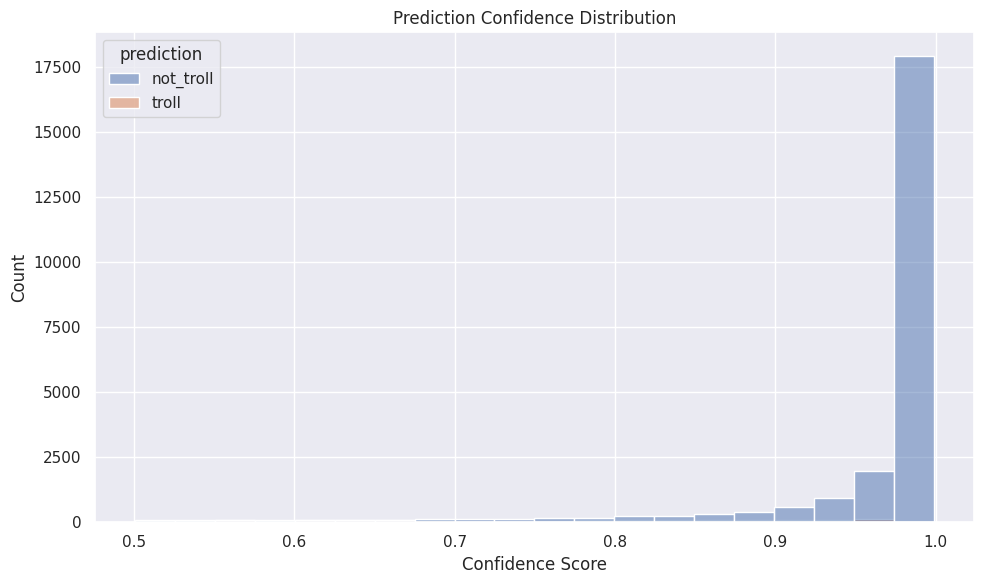

In [9]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




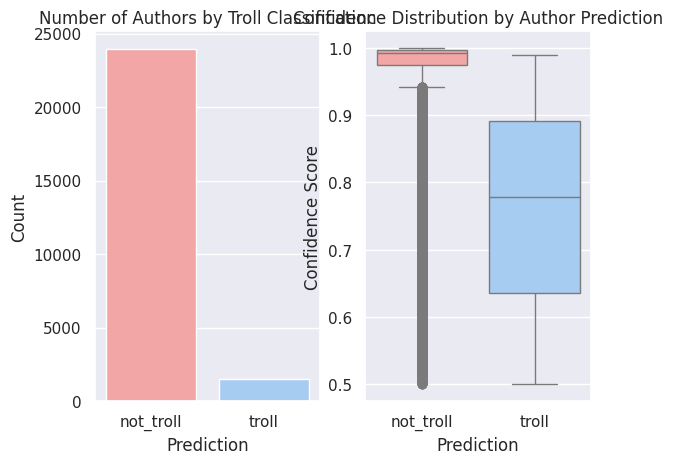

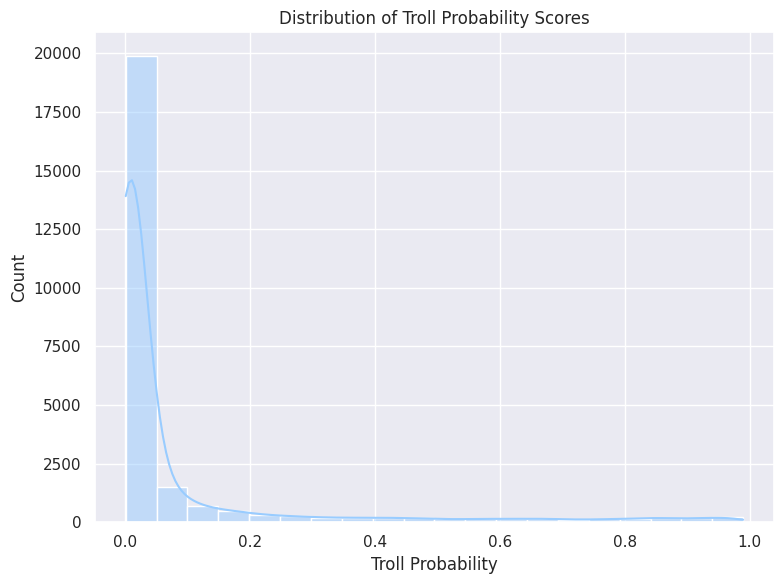

In [10]:
# Count plot of authors per prediction group
plt.subplot(1, 2, 1)
sns.countplot(data=results_df, x='prediction', hue='prediction', palette=['#FF9999','#99CCFF'],legend=False)
plt.title('Number of Authors by Troll Classification')
plt.xlabel('Prediction')
plt.ylabel('Count')

# Boxplot for confidence distribution per prediction group
plt.subplot(1, 2, 2)
sns.boxplot(data=results_df, x='prediction', hue='prediction', y='confidence', palette=['#FF9999','#99CCFF'], legend=False)
plt.title('Confidence Distribution by Author Prediction')
plt.xlabel('Prediction')
plt.ylabel('Confidence Score')

# Distribution of troll probability scores
plt.figure(figsize=(8, 6))
sns.histplot(data=results_df, x='troll_probability', bins=20, kde=True, color='#99CCFF', legend=False)
plt.title('Distribution of Troll Probability Scores')
plt.xlabel('Troll Probability')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [11]:
# Save a sample of troll and not_troll classified comments

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='troll',
    min_confidence=0.7,
    max_confidence=0.9,
    max_authors=50,
    output_file="../output/troll_comments.json"
)

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='not_troll',
    min_confidence=0.8,
    max_authors=50,
    output_file="../output/non_troll_comments.json"
)

Processing troll comments:   0%|                                                     | 0/50 [00:00<?, ?it/s]

Processing troll comments:  10%|████▌                                        | 5/50 [00:00<00:01, 41.34it/s]

Processing troll comments:  20%|████████▊                                   | 10/50 [00:00<00:01, 39.81it/s]

Processing troll comments:  30%|█████████████▏                              | 15/50 [00:00<00:00, 41.81it/s]

Processing troll comments:  40%|█████████████████▌                          | 20/50 [00:00<00:00, 41.65it/s]

Processing troll comments:  50%|██████████████████████                      | 25/50 [00:00<00:00, 40.93it/s]

Processing troll comments:  60%|██████████████████████████▍                 | 30/50 [00:00<00:00, 42.15it/s]

Processing troll comments:  70%|██████████████████████████████▊             | 35/50 [00:00<00:00, 43.03it/s]

Processing troll comments:  80%|███████████████████████████████████▏        | 40/50 [00:00<00:00, 43.31it/s]

Processing troll comments:  90%|███████████████████████████████████████▌    | 45/50 [00:01<00:00, 43.12it/s]

Processing troll comments: 100%|████████████████████████████████████████████| 50/50 [00:01<00:00, 42.93it/s]

Processing troll comments: 100%|████████████████████████████████████████████| 50/50 [00:01<00:00, 42.34it/s]


Exported 2398 comments from 50 authors
Output saved to: ../output/troll_comments.json


Processing not_troll comments:   0%|                                                 | 0/50 [00:00<?, ?it/s]

Processing not_troll comments:  10%|████                                     | 5/50 [00:00<00:00, 45.15it/s]

Processing not_troll comments:  20%|████████                                | 10/50 [00:00<00:00, 44.72it/s]

Processing not_troll comments:  30%|████████████                            | 15/50 [00:00<00:00, 44.37it/s]

Processing not_troll comments:  40%|████████████████                        | 20/50 [00:00<00:00, 44.64it/s]

Processing not_troll comments:  50%|████████████████████                    | 25/50 [00:00<00:00, 44.98it/s]

Processing not_troll comments:  60%|████████████████████████                | 30/50 [00:00<00:00, 45.27it/s]

Processing not_troll comments: 100%|██████████████████████████████████████| 50/50 [00:00<00:00, -195.19it/s]


Exported 947 comments from 50 authors
Output saved to: ../output/non_troll_comments.json


In [12]:
def explain_author(
    author_name: str, 
    predictor_instance: TrollPredictor, 
    comments_df: pd.DataFrame, 
    display_plots: bool = True,
):
    """Interactive function to explain why an author was classified as a troll using multiple methods"""
    
    # Get author's comments
    author_comments = comments_df[comments_df['author'] == author_name]['text'].tolist()
    
    if not author_comments:
        print(f'No comments found for author: {author_name}')
        return
        
    # Get prediction first
    pred = predictor_instance.predict_batch(author_comments)
    
    if pred['prediction'] != 'troll':
        print(f'Author {author_name} is not classified as a troll (confidence: {pred["confidence"]:.3f})')
        return
    
    print(f"\nAnalyzing author: {author_name}")
    print(f"Prediction confidence: {pred['confidence']:.3f}")
    print(f"Troll probability: {pred['probabilities'][1]:.3f}")
    
    # Generate occlusion sensitivity explanation
    print("\n=== Occlusion Sensitivity Analysis ===")
    explanation = predictor_instance.explain_prediction(author_comments)
    
    # Print occlusion sensitivity results
    for i, exp in enumerate(explanation['explanations'], 1):
        print(f"\nComment {i}:")
        print(f"Text: {exp['tweet_text']}")
        print("\nMost influential tokens (Occlusion Sensitivity):")
        
        # Create a table with token contributions
        contrib_data = []
        for contrib in exp['token_contributions']:
            direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
            contrib_data.append([
                contrib['token'],
                f"{contrib['importance']:.4f}",
                direction
            ])
        
        contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
        print(contrib_df.to_string(index=False))
        
        if display_plots:
            img = plt.imread(exp['plot_filename'])
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Occlusion Sensitivity Analysis - Comment {i}')
            plt.show()
        
        print("-" * 80)

In [13]:
# Example usage
# authors_to_explain = [
#     "Jitka Bártová",
#     "Roman Myška",   
# ]
authors_to_explain = [
    "Josef Hůzl",
    "Johny Death",   
]


for author in authors_to_explain:
    explain_author(
        author_name=author,
        predictor_instance=predictor,
        comments_df=czech_comments,
        display_plots=True,
    )
    print("\n" + "="*80 + "\n")

No comments found for author: Josef Hůzl


No comments found for author: Johny Death




In [14]:
# List names of medium confidence trolls
medium_conf_trolls = results_df[
    (results_df['confidence'] >= 0.6) & 
    (results_df['confidence'] < 0.7) & 
    (results_df['prediction'] == 'troll')
]

# Display the names
medium_conf_troll_names = medium_conf_trolls['author'].tolist()
print("Medium confidence trolls (confidence between 0.6 and 0.7):")
print(medium_conf_troll_names)

Medium confidence trolls (confidence between 0.6 and 0.7):
['Adam Otte', 'Adam Valenta', 'Aldama Aleš', 'Alena Boudová', 'Ales Ponec', 'Aleš Blecha', 'Aleš Burian', 'Aleš Grau', 'Aleš Linhardt', 'Anna Procházková', 'Antonín Voříšek,', 'Antonín Ďuriš', 'Antonín Šiška', 'Bohous Skopal', 'Bořivoj Vávra', 'Bronislav Peschel', 'Dalibor Hejl', 'Dan Koles', 'Dan Planka', 'Dana Beránková', 'Daniel Pospíšil', 'Daniel Veselý', 'David Horák', 'David Härtel', 'Drahomír Krejčí', 'Dáša Třetinová', 'Eva Brichnacova', 'Eva Haaf', 'František Eliáš', 'František Horák', 'František Mitura', 'František Málek', 'František Stropek', 'Gustav Kinčl', 'Honza Husák', 'Honza Hába', 'Honzatichý', 'Hrazdil Pavel', 'Igor Minjarik', 'Ilia Tichý', 'Innside Kalim Festek', 'Irena Březíková', 'Ivan Kaňkovský', 'Ivan Ponocný', 'Ivana Kojzarova', 'Ivana Pletanek', 'Iveta Gondárová', 'Iveta Poláková', 'Iveta Škodová', 'Jakub Jáchym', 'Jakub Procházka', 'Jakub Ševčík', 'Jan Beneš', 'Jan Gostík', 'Jan Hak', 'Jan Jelínek', 'Ja